In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.function import Function
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools
import random
import tqdm
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import math
import logging
from functools import partial
from collections import OrderedDict
from sklearn.metrics import classification_report
from torchsummary import summary

In [2]:
!nvidia-smi
torch.cuda.is_available()

Tue Aug 17 13:17:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 35%   25C    P8    31W / 260W |    972MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

## Read the data of EEG&EOG

In [6]:
###Read the EEG Spectrogram###

dat1 = np.load('/project/hikaku_db/data/sleep_SHHS/stages_sig/C4_spec_30_np/spec_5007_5793_30.npy')
dat2 = np.load('/project/hikaku_db/data/sleep_SHHS/stages_sig/C3_spec_30_np/spec_c3_5007_5793_30.npy')
print(dat1.shape)
print(dat2.shape)

(786606, 32, 30)
(786606, 32, 30)


In [7]:
dat = np.concatenate((dat1.reshape(-1,1,32,30), dat2.reshape(-1,1,32,30)), axis=1)
print(dat.shape)        
fixdata = dat[:,:,0:16,:]  
mean_p1 = np.mean(dat[:,:,16:20,:], axis = 2)
mean_p2 = np.mean(dat[:,:,20:24,:], axis = 2)
mean_p3 = np.mean(dat[:,:,24:28,:], axis = 2)
mean_p4 = np.mean(dat[:,:,28:32,:], axis = 2)
num_data = len(dat)
ch = 2
inputdat = np.concatenate((fixdata,mean_p1.reshape(num_data, ch, 1, 30),mean_p2.reshape(num_data, ch, 1, 30),mean_p3.reshape(num_data, ch, 1, 30),mean_p4.reshape(num_data, ch, 1, 30)),axis=2)
print(inputdat.shape)

(786606, 2, 32, 30)
(786606, 2, 20, 30)


In [8]:
###Read the Lable###
index = pd.read_csv("/project/hikaku_db/data/sleep_SHHS/stages_sig/ann_delrecords_5class.csv", header=None)
index = index[5007610 : 5794216].astype(int)
print(index.apply(pd.value_counts))
label = index.values.tolist()  #list

        0
2  317703
0  220808
4  118212
3   97754
1   32129


In [9]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data,label ,transform = None):
        self.transform = transform

        self.data = data
        self.label = label

        self.datanum = len(data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data = torch.tensor(self.data[idx]).float()
        out_label = torch.tensor(self.label[idx])
        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

In [10]:
train, test, train_label, test_label = train_test_split(inputdat, np.array(label),test_size = 0.1,stratify = label, random_state = 0)
print('train data:',len(train))
print('test data:',len(test))

train_data_set = Mydatasets(data=train,label=train_label)
test_data_set = Mydatasets(data=test,label=test_label)

train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 64, shuffle=False)

train data: 707945
test data: 78661


In [11]:
##LSTM model

class LSTM(nn.Module):
    def __init__(self,LSTM_hidden_size,LSTM_num_layers):
        super().__init__()
        self.to_patch = nn.Sequential(
            #(batch, 2, 20, 30) -> (batch, 30, 40) 
            Rearrange('b c s t -> b t (c s)') 
        )
        
        self.lstm = nn.LSTM(
            input_size = 40,
            hidden_size = LSTM_hidden_size,
            num_layers = LSTM_num_layers,
            batch_first=True
        )
        
        self.to_patches = nn.Sequential( 
            #(batch, 30, LSTM_hidden_size) -> (batch, 1, 30, LSTM_hidden_size) 
            Rearrange('b t (s c) -> b c t s', c=1),
            nn.Linear(LSTM_hidden_size, 4),   # -> (batch, 1, 30, 4)
            Rearrange('b c t s -> b c s t')   # -> (batch, 1, 4, 30)    
        )
        
    def forward(self,x):
        # output: [batch_size, time_step, hidden_size] ,same as input: [batch, seq_len, input_size]
        # LSTM : batch_first = True, but the first dim of h_n and c_n will still be num_layers
        # h_n and c_n: [num_layers,batch_size, hidden_size] 
        x = self.to_patch(x)
        output,(h_n,c_n)=self.lstm(x) 
        out = self.to_patches(output)
        x_1 = out.clone()
        out = torch.cat((out, x_1), dim=2)
        out = torch.cat((out, x_1), dim=2)
        out = torch.cat((out, x_1), dim=2)
        out = torch.cat((out, x_1), dim=2)       # -> (batch, 1, 20, 30) 
        return out

In [12]:
##Transformer model

class PreNorm(nn.Module): 
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, mlp_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, mlp_dim),       #output_of_attention_dim to mlp_dim
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),      #mlp_dim to output_of_attention_dim(==input_of_attention_dim)
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 8, dropout = 0.):
        super().__init__()
        inner_dim = dim_head * heads       ##qkv_dim(inner_dim) = head_num * head_dim     32 = 4*8
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)   ##embedding_dim to qkv_dim * 3

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale #dots for attention-value(scaled) of Q -> K
        
        attn = self.attend(dots)             #atte for Softmax(attention-value)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)        #out for Z = attn * V
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)             #out_dim(==inner_dim==Z_dim) to embedding_dim

class Transformer(nn.Module):           ##Register the blocks into whole network
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x     #Residuals cut-in
            x = ff(x) + x
        return x

class LSTM_ViT(nn.Module):                   
    def __init__(self, *, LSTM_hidden_size, LSTM_num_layers, image_size, time_size, fre_size, num_classes, 
                 dim, depth, heads, mlp_dim, pool = 'cls', channels , dim_head, dropout = 0, emb_dropout = 0.):
        super().__init__()
        assert image_size == 30  #Time dimensions must equal to 30s
        num_patches = 150       #30*5'
        patch_dim = channels * time_size * fre_size    #3*1*4'
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        
        self.lstm = LSTM(LSTM_hidden_size, LSTM_num_layers)
               
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = fre_size, p2 = time_size),  #（batch, 5, 480）
            nn.Linear(patch_dim, dim),        #patch_dim(20) to embedding_dim
        )
                
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))  #Generate the pos value'
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))                    #Generate the class value'
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        lstm_out = self.lstm(img)
        x = torch.cat((lstm_out, img), dim=1)
        x = self.to_patch_embedding(x)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [13]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

Transmodel = LSTM_ViT(
    LSTM_hidden_size = 32,
    LSTM_num_layers = 4,
    image_size = 30, 
    time_size = 1, 
    fre_size = 4, 
    num_classes = 5, 
    dim = 64, 
    depth = 3,  
    heads = 4,      #4
    mlp_dim = 256,  
    channels = 3,
    dim_head = 8   #8
).to(DEVICE)

#summary(Transmodel,(2286886, 20, 30))

optimizer = torch.optim.AdamW(Transmodel.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

Transmodel.load_state_dict(torch.load('/project/hikaku_db/ziwei/Model_15/Model_15_state_6'))

cuda:0


<All keys matched successfully>

In [14]:
EPOCH = 100
loss_list=[]
los_min=10**10
val_loss_list=[]
ac_list=[]

for epoch in tqdm.tqdm(range(EPOCH)):
    running_loss = 0.0
    count=0
    for _, (inputs1, labels) in enumerate(train_dataloader, 0):

        optimizer.zero_grad()
        inputs1 = inputs1.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = Transmodel(inputs1)
        
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()
        count=count+1

        # print statistics
        running_loss += loss.item()
    loss_loss=running_loss/count
    loss_list.append(loss_loss)
    print('epoch',epoch+1,':finished')
    print('train_loss:',loss_loss)
    with torch.no_grad():
        count=0
        running_loss=0.0
        pre=list()
        lab=list()
        for _, (inputs1, labels) in enumerate(test_dataloader, 0):
            inputs1=inputs1.to(DEVICE)
            labels=labels.to(DEVICE)
            outputs = Transmodel(inputs1)
            loss =criterion(outputs, labels.squeeze())
            running_loss += loss.item()
            count+=1
            _, predicted = torch.max(F.softmax(outputs).data, 1)
            predicted=predicted.to('cpu')
            labels=labels.to('cpu')
            predicted=predicted.tolist()
            labels=labels.tolist()
            pre.append(predicted)
            lab.append(labels)
        loss_loss=running_loss/count
        val_loss_list.append(loss_loss)
        pre=sum(pre,[])
        lab=sum(lab,[])
        print('val_loss:',loss_loss)
        cl = classification_report(lab, pre,output_dict=True)
        print(cl)
        ac_list.append(cl['accuracy'])
#         if los_min>loss_loss:
#             los_min=loss_loss
#             torch.save(Transmodel.state_dict(),'Trans_8lay_state') 

        torch.save(Transmodel.state_dict(),'/project/hikaku_db/ziwei/Model_15/Model_15_state_7')

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 1 :finished
train_loss: 0.39563674388527115


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


val_loss: 0.3737208217624726
{'0': {'precision': 0.9231915470062314, 'recall': 0.9259091526651873, 'f1-score': 0.9245483528161531, 'support': 22081}, '1': {'precision': 0.46402877697841727, 'recall': 0.20074696545284781, 'f1-score': 0.28025200955898333, 'support': 3213}, '2': {'precision': 0.8658544014620774, 'recall': 0.8947153064115073, 'f1-score': 0.880048296465999, 'support': 31771}, '3': {'precision': 0.8693046802355615, 'recall': 0.86076726342711, 'f1-score': 0.8650149069600082, 'support': 9775}, '4': {'precision': 0.7925649968294229, 'recall': 0.8458675238981473, 'f1-score': 0.8183492245365633, 'support': 11821}, 'accuracy': 0.8635664433454953, 'macro avg': {'precision': 0.782988880502342, 'recall': 0.7456012423709599, 'f1-score': 0.7536425580675413, 'support': 78661}, 'weighted avg': {'precision': 0.8549515169594987, 'recall': 0.8635664433454953, 'f1-score': 0.8569004107632566, 'support': 78661}}


  1%|          | 1/100 [03:02<5:01:25, 182.68s/it]

epoch 2 :finished
train_loss: 0.3670106312787742


  2%|▏         | 2/100 [06:06<4:58:44, 182.90s/it]

val_loss: 0.36879585202389614
{'0': {'precision': 0.9037226657410621, 'recall': 0.9432996693990309, 'f1-score': 0.923087150169514, 'support': 22081}, '1': {'precision': 0.472289156626506, 'recall': 0.1830065359477124, 'f1-score': 0.26379542395693134, 'support': 3213}, '2': {'precision': 0.8607014388489208, 'recall': 0.9037487016461553, 'f1-score': 0.8816999585450861, 'support': 31771}, '3': {'precision': 0.8835354179961711, 'recall': 0.8498209718670077, 'f1-score': 0.8663503154820879, 'support': 9775}, '4': {'precision': 0.8275891780113734, 'recall': 0.8125370104052111, 'f1-score': 0.8199940239894139, 'support': 11821}, 'accuracy': 0.8650029875033372, 'macro avg': {'precision': 0.7895675714448067, 'recall': 0.7384825778530234, 'f1-score': 0.7509853744286066, 'support': 78661}, 'weighted avg': {'precision': 0.8547742978136996, 'recall': 0.8650029875033372, 'f1-score': 0.8568982740420139, 'support': 78661}}
epoch 3 :finished
train_loss: 0.3554790778928511


  3%|▎         | 3/100 [09:09<4:56:09, 183.19s/it]

val_loss: 0.36401924457613044
{'0': {'precision': 0.93284845158044, 'recall': 0.9235541868574793, 'f1-score': 0.9281780528878977, 'support': 22081}, '1': {'precision': 0.45166487647690656, 'recall': 0.2617491441020853, 'f1-score': 0.3314285714285714, 'support': 3213}, '2': {'precision': 0.859652262085831, 'recall': 0.9072739290547984, 'f1-score': 0.8828213530979144, 'support': 31771}, '3': {'precision': 0.9032003606040118, 'recall': 0.8199488491048593, 'f1-score': 0.8595635154699984, 'support': 9775}, '4': {'precision': 0.8048352349796537, 'recall': 0.8533119025463158, 'f1-score': 0.8283649503161697, 'support': 11821}, 'accuracy': 0.8665158083421264, 'macro avg': {'precision': 0.7904402371453686, 'recall': 0.7531676023331076, 'f1-score': 0.7660712886401103, 'support': 78661}, 'weighted avg': {'precision': 0.8607083403948034, 'recall': 0.8665158083421264, 'f1-score': 0.8619574151930206, 'support': 78661}}
epoch 4 :finished
train_loss: 0.3476195923412898


  4%|▍         | 4/100 [12:12<4:52:35, 182.87s/it]

val_loss: 0.3596814084767811
{'0': {'precision': 0.9343337004405287, 'recall': 0.922104977129659, 'f1-score': 0.9281790622934378, 'support': 22081}, '1': {'precision': 0.4686746987951807, 'recall': 0.24214130096483039, 'f1-score': 0.3193104863533757, 'support': 3213}, '2': {'precision': 0.8734204591095869, 'recall': 0.8898051682351831, 'f1-score': 0.8815366865196919, 'support': 31771}, '3': {'precision': 0.8450731331793687, 'recall': 0.8984143222506394, 'f1-score': 0.8709277532602766, 'support': 9775}, '4': {'precision': 0.8082730923694779, 'recall': 0.8512816174604517, 'f1-score': 0.8292200568579787, 'support': 11821}, 'accuracy': 0.8676980968968103, 'macro avg': {'precision': 0.7859550167788285, 'recall': 0.7607494772081527, 'f1-score': 0.7658348090569521, 'support': 78661}, 'weighted avg': {'precision': 0.8606743081673872, 'recall': 0.8676980968968103, 'f1-score': 0.8624845554316536, 'support': 78661}}
epoch 5 :finished
train_loss: 0.34175611000027845


  5%|▌         | 5/100 [15:14<4:49:25, 182.80s/it]

val_loss: 0.35691647828836753
{'0': {'precision': 0.9163535081126487, 'recall': 0.9386803133916036, 'f1-score': 0.9273825503355705, 'support': 22081}, '1': {'precision': 0.4551282051282051, 'recall': 0.26517273576097106, 'f1-score': 0.3351032448377581, 'support': 3213}, '2': {'precision': 0.8574543954262812, 'recall': 0.9158037203739259, 'f1-score': 0.8856690612443687, 'support': 31771}, '3': {'precision': 0.8987203324948048, 'recall': 0.840613810741688, 'f1-score': 0.868696479543292, 'support': 9775}, '4': {'precision': 0.8551469262664503, 'recall': 0.8025547753997124, 'f1-score': 0.8280165830242199, 'support': 11821}, 'accuracy': 0.869287194416547, 'macro avg': {'precision': 0.796560673485678, 'recall': 0.7525650711335802, 'f1-score': 0.768973583797042, 'support': 78661}, 'weighted avg': {'precision': 0.862335787726232, 'recall': 0.869287194416547, 'f1-score': 0.8641169662206591, 'support': 78661}}
epoch 6 :finished
train_loss: 0.3365457948486524


  6%|▌         | 6/100 [18:19<4:47:14, 183.35s/it]

val_loss: 0.3590855379475326
{'0': {'precision': 0.9386423580583962, 'recall': 0.9186631040260858, 'f1-score': 0.9285452714455735, 'support': 22081}, '1': {'precision': 0.47452896022330776, 'recall': 0.21164021164021163, 'f1-score': 0.29272492466637967, 'support': 3213}, '2': {'precision': 0.8811444652908067, 'recall': 0.8869409209656605, 'f1-score': 0.8840331916362095, 'support': 31771}, '3': {'precision': 0.8870830677714043, 'recall': 0.8543222506393862, 'f1-score': 0.870394496847152, 'support': 9775}, '4': {'precision': 0.7513885959361597, 'recall': 0.9040690296929194, 'f1-score': 0.8206880663492552, 'support': 11821}, 'accuracy': 0.8667827767254421, 'macro avg': {'precision': 0.7865574894560149, 'recall': 0.7551271033928526, 'f1-score': 0.7592771901889139, 'support': 78661}, 'weighted avg': {'precision': 0.8619146189886472, 'recall': 0.8667827767254421, 'f1-score': 0.8611613339801459, 'support': 78661}}
epoch 7 :finished
train_loss: 0.3320623492790732


  7%|▋         | 7/100 [21:22<4:44:01, 183.24s/it]

val_loss: 0.35166508420938397
{'0': {'precision': 0.9324846556035462, 'recall': 0.9288528599248222, 'f1-score': 0.9306652146292766, 'support': 22081}, '1': {'precision': 0.47566909975669097, 'recall': 0.24338624338624337, 'f1-score': 0.3220094708667902, 'support': 3213}, '2': {'precision': 0.8797125793206421, 'recall': 0.8901513959271034, 'f1-score': 0.8849012030851546, 'support': 31771}, '3': {'precision': 0.8666263725193916, 'recall': 0.8801023017902814, 'f1-score': 0.8733123540757284, 'support': 9775}, '4': {'precision': 0.7964007105893257, 'recall': 0.8722612300143812, 'f1-score': 0.8326065891472868, 'support': 11821}, 'accuracy': 0.8706601746735994, 'macro avg': {'precision': 0.7901786835579193, 'recall': 0.7629508062085664, 'f1-score': 0.7686989663608473, 'support': 78661}, 'weighted avg': {'precision': 0.8638765391585378, 'recall': 0.8706601746735994, 'f1-score': 0.8654568580204017, 'support': 78661}}
epoch 8 :finished
train_loss: 0.3283820659160625


  8%|▊         | 8/100 [24:25<4:40:48, 183.13s/it]

val_loss: 0.3471875517288359
{'0': {'precision': 0.9383379247015611, 'recall': 0.9255468502332322, 'f1-score': 0.9318984975262763, 'support': 22081}, '1': {'precision': 0.4456575682382134, 'recall': 0.27948957360722065, 'f1-score': 0.3435348125478194, 'support': 3213}, '2': {'precision': 0.8727571315613406, 'recall': 0.9032765729753549, 'f1-score': 0.8877546285555195, 'support': 31771}, '3': {'precision': 0.8795979691223708, 'recall': 0.8684398976982097, 'f1-score': 0.8739833213219397, 'support': 9775}, '4': {'precision': 0.8196708019135652, 'recall': 0.855172997208358, 'f1-score': 0.8370456239132235, 'support': 11821}, 'accuracy': 0.872490815016336, 'macro avg': {'precision': 0.7912042791074102, 'recall': 0.7663851783444752, 'f1-score': 0.7748433767729557, 'support': 78661}, 'weighted avg': {'precision': 0.8665933945222071, 'recall': 0.872490815016336, 'f1-score': 0.8685852413093075, 'support': 78661}}
epoch 9 :finished
train_loss: 0.32496088408061685


  9%|▉         | 9/100 [27:28<4:37:42, 183.11s/it]

val_loss: 0.3553997536136852
{'0': {'precision': 0.9174942365667672, 'recall': 0.9372311036637834, 'f1-score': 0.9272576562044941, 'support': 22081}, '1': {'precision': 0.4396112910689496, 'recall': 0.2956738250855898, 'f1-score': 0.3535541496092297, 'support': 3213}, '2': {'precision': 0.8782161762895482, 'recall': 0.8981461080859904, 'f1-score': 0.8880693400557086, 'support': 31771}, '3': {'precision': 0.8929801894918173, 'recall': 0.8484910485933503, 'f1-score': 0.8701673398730524, 'support': 9775}, '4': {'precision': 0.8212758960868135, 'recall': 0.8451061669909483, 'f1-score': 0.8330206378986866, 'support': 11821}, 'accuracy': 0.8703677807299678, 'macro avg': {'precision': 0.7899155579007792, 'recall': 0.7649296504839324, 'f1-score': 0.7744138247282343, 'support': 78661}, 'weighted avg': {'precision': 0.8646044567530962, 'recall': 0.8703677807299678, 'f1-score': 0.8667398011735837, 'support': 78661}}
epoch 10 :finished
train_loss: 0.3216663697915318


 10%|█         | 10/100 [30:33<4:35:26, 183.63s/it]

val_loss: 0.3490328740782854
{'0': {'precision': 0.9349961171257595, 'recall': 0.9269507721570581, 'f1-score': 0.9309560629491495, 'support': 22081}, '1': {'precision': 0.46266044340723456, 'recall': 0.24680983504512916, 'f1-score': 0.3218997361477573, 'support': 3213}, '2': {'precision': 0.8724533365865561, 'recall': 0.9003808504611124, 'f1-score': 0.8861971220124228, 'support': 31771}, '3': {'precision': 0.8647434617688161, 'recall': 0.8862404092071611, 'f1-score': 0.875359975749002, 'support': 9775}, '4': {'precision': 0.82, 'recall': 0.8497589036460537, 'f1-score': 0.8346142661293672, 'support': 11821}, 'accuracy': 0.871778899327494, 'macro avg': {'precision': 0.7909706717776731, 'recall': 0.7620281541033028, 'f1-score': 0.7698054325975398, 'support': 78661}, 'weighted avg': {'precision': 0.8644306525775542, 'recall': 0.871778899327494, 'f1-score': 0.8666136006984573, 'support': 78661}}
epoch 11 :finished
train_loss: 0.3189669962379023


 11%|█         | 11/100 [33:37<4:32:32, 183.74s/it]

val_loss: 0.3540393249775336
{'0': {'precision': 0.9258361391694725, 'recall': 0.9339703817761876, 'f1-score': 0.9298854720894579, 'support': 22081}, '1': {'precision': 0.5037159372419489, 'recall': 0.18985371926548397, 'f1-score': 0.2757685352622061, 'support': 3213}, '2': {'precision': 0.8804381748954497, 'recall': 0.8879481287967014, 'f1-score': 0.8841772052716531, 'support': 31771}, '3': {'precision': 0.8481892805408016, 'recall': 0.8985166240409207, 'f1-score': 0.8726279185295578, 'support': 9775}, '4': {'precision': 0.8015338863671936, 'recall': 0.8664241603925218, 'f1-score': 0.8327167771047604, 'support': 11821}, 'accuracy': 0.8704313446307573, 'macro avg': {'precision': 0.7919426836429733, 'recall': 0.755342602854363, 'f1-score': 0.7590351816515272, 'support': 78661}, 'weighted avg': {'precision': 0.8619291724996602, 'recall': 0.8704313446307573, 'f1-score': 0.8629882956925577, 'support': 78661}}
epoch 12 :finished
train_loss: 0.3162770605439132


 12%|█▏        | 12/100 [36:42<4:30:03, 184.14s/it]

val_loss: 0.3524280954727797
{'0': {'precision': 0.941816834205772, 'recall': 0.9207463430098275, 'f1-score': 0.9311624072547403, 'support': 22081}, '1': {'precision': 0.45829145728643217, 'recall': 0.2838468720821662, 'f1-score': 0.35056698058812225, 'support': 3213}, '2': {'precision': 0.8724460278310648, 'recall': 0.9018287117182336, 'f1-score': 0.8868940754039498, 'support': 31771}, '3': {'precision': 0.8608283087871899, 'recall': 0.8909462915601023, 'f1-score': 0.8756283933239494, 'support': 9775}, '4': {'precision': 0.8243443839683325, 'recall': 0.8456137382624144, 'f1-score': 0.8348436129786612, 'support': 11821}, 'accuracy': 0.8720967188314412, 'macro avg': {'precision': 0.7915454024157582, 'recall': 0.7685963913265488, 'f1-score': 0.7758190939098846, 'support': 78661}, 'weighted avg': {'precision': 0.8663302322607667, 'recall': 0.8720967188314412, 'f1-score': 0.8681917899167669, 'support': 78661}}
epoch 13 :finished
train_loss: 0.31393998041829824


 13%|█▎        | 13/100 [39:44<4:26:08, 183.55s/it]

val_loss: 0.35561508295860716
{'0': {'precision': 0.9121086052112984, 'recall': 0.9432543815950365, 'f1-score': 0.9274200730252027, 'support': 22081}, '1': {'precision': 0.44790547798066593, 'recall': 0.25957049486461253, 'f1-score': 0.3286699507389163, 'support': 3213}, '2': {'precision': 0.8623629719853837, 'recall': 0.9136634037329641, 'f1-score': 0.8872722826751437, 'support': 31771}, '3': {'precision': 0.9039635838792051, 'recall': 0.8329411764705882, 'f1-score': 0.867000319454797, 'support': 9775}, '4': {'precision': 0.8528682719546742, 'recall': 0.8149902715506302, 'f1-score': 0.8334991564649391, 'support': 11821}, 'accuracy': 0.8703932062902836, 'macro avg': {'precision': 0.7958417822022456, 'recall': 0.7528839456427663, 'f1-score': 0.7687723564717998, 'support': 78661}, 'weighted avg': {'precision': 0.8631408737565708, 'recall': 0.8703932062902836, 'f1-score': 0.8651253928669648, 'support': 78661}}
epoch 14 :finished
train_loss: 0.3115172762140198


 14%|█▍        | 14/100 [42:51<4:24:33, 184.58s/it]

val_loss: 0.3608896981409895
{'0': {'precision': 0.944348475652458, 'recall': 0.9160364113944115, 'f1-score': 0.9299770114942528, 'support': 22081}, '1': {'precision': 0.4708029197080292, 'recall': 0.24089635854341737, 'f1-score': 0.31871525633106856, 'support': 3213}, '2': {'precision': 0.8737142681691179, 'recall': 0.8956595637531082, 'f1-score': 0.8845508237488344, 'support': 31771}, '3': {'precision': 0.8919646704006894, 'recall': 0.8471611253196931, 'f1-score': 0.868985780995855, 'support': 9775}, '4': {'precision': 0.7677700982175336, 'recall': 0.8927332712968445, 'f1-score': 0.8255495580067277, 'support': 11821}, 'accuracy': 0.8681684697626524, 'macro avg': {'precision': 0.7897200864295656, 'recall': 0.7584973460614949, 'f1-score': 0.7655556861153476, 'support': 78661}, 'weighted avg': {'precision': 0.8634315540115314, 'recall': 0.8681684697626524, 'f1-score': 0.8633894314228467, 'support': 78661}}
epoch 15 :finished
train_loss: 0.3090918456225957


 15%|█▌        | 15/100 [45:56<4:21:45, 184.77s/it]

val_loss: 0.35269028059835356
{'0': {'precision': 0.927041529512558, 'recall': 0.9310719623205471, 'f1-score': 0.9290523747119165, 'support': 22081}, '1': {'precision': 0.47725816784112746, 'recall': 0.23187052598817304, 'f1-score': 0.3121072475911186, 'support': 3213}, '2': {'precision': 0.8819605386783589, 'recall': 0.8863743665607, 'f1-score': 0.8841619440825104, 'support': 31771}, '3': {'precision': 0.8652979469203805, 'recall': 0.8838874680306905, 'f1-score': 0.8744939271255061, 'support': 9775}, '4': {'precision': 0.7931273062730627, 'recall': 0.8727688012858472, 'f1-score': 0.8310443433082283, 'support': 11821}, 'accuracy': 0.8698338439633363, 'macro avg': {'precision': 0.7889370978450974, 'recall': 0.7611946248371917, 'f1-score': 0.766171967363856, 'support': 78661}, 'weighted avg': {'precision': 0.8626644474312694, 'recall': 0.8698338439633363, 'f1-score': 0.8642131236301078, 'support': 78661}}
epoch 16 :finished
train_loss: 0.307227957036324


 16%|█▌        | 16/100 [48:54<4:15:49, 182.74s/it]

val_loss: 0.35078890195828144
{'0': {'precision': 0.9332848572986729, 'recall': 0.9300303428286762, 'f1-score': 0.9316547578541454, 'support': 22081}, '1': {'precision': 0.45542427497314714, 'recall': 0.26392779333955807, 'f1-score': 0.33418719211822656, 'support': 3213}, '2': {'precision': 0.8638730990149103, 'recall': 0.913631928488244, 'f1-score': 0.888056048461115, 'support': 31771}, '3': {'precision': 0.8883372068455525, 'recall': 0.8602557544757033, 'f1-score': 0.8740709942310692, 'support': 9775}, '4': {'precision': 0.8382503410641201, 'recall': 0.8316555282970984, 'f1-score': 0.8349399125228248, 'support': 11821}, 'accuracy': 0.8727450706194938, 'macro avg': {'precision': 0.7958339558392806, 'recall': 0.7599002694858561, 'f1-score': 0.7725817810374761, 'support': 78661}, 'weighted avg': {'precision': 0.8658637296365121, 'recall': 0.8727450706194938, 'f1-score': 0.8679512025864451, 'support': 78661}}
epoch 17 :finished
train_loss: 0.30549128586906266


 17%|█▋        | 17/100 [51:54<4:11:45, 182.00s/it]

val_loss: 0.3498139573003703
{'0': {'precision': 0.9255653266331658, 'recall': 0.934242108600154, 'f1-score': 0.9298834772025514, 'support': 22081}, '1': {'precision': 0.46623605402231355, 'recall': 0.24712107065048242, 'f1-score': 0.323026851098454, 'support': 3213}, '2': {'precision': 0.8811245229155676, 'recall': 0.8937710490699066, 'f1-score': 0.8874027313353542, 'support': 31771}, '3': {'precision': 0.8752304855562385, 'recall': 0.8740664961636828, 'f1-score': 0.8746481035983007, 'support': 9775}, '4': {'precision': 0.8069552874378992, 'recall': 0.8656628034853228, 'f1-score': 0.8352787527548772, 'support': 11821}, 'accuracy': 0.8720458677108097, 'macro avg': {'precision': 0.791022335313037, 'recall': 0.7629727055939097, 'f1-score': 0.7700479831979076, 'support': 78661}, 'weighted avg': {'precision': 0.8647745145068937, 'recall': 0.8720458677108097, 'f1-score': 0.8668568904404114, 'support': 78661}}
epoch 18 :finished
train_loss: 0.3031487062407071


 18%|█▊        | 18/100 [54:55<4:08:13, 181.63s/it]

val_loss: 0.35331694825393395
{'0': {'precision': 0.9170525201746262, 'recall': 0.9418051718672161, 'f1-score': 0.929264042182403, 'support': 22081}, '1': {'precision': 0.49445676274944567, 'recall': 0.20821661998132587, 'f1-score': 0.29303547963206306, 'support': 3213}, '2': {'precision': 0.8584560989982322, 'recall': 0.917062730162727, 'f1-score': 0.8867921656952413, 'support': 31771}, '3': {'precision': 0.8984925713046308, 'recall': 0.8475703324808184, 'f1-score': 0.8722889029269321, 'support': 9775}, '4': {'precision': 0.8471665213600698, 'recall': 0.8220116741392437, 'f1-score': 0.8343995534755914, 'support': 11821}, 'accuracy': 0.872134857171915, 'macro avg': {'precision': 0.8031248949174008, 'recall': 0.7473333057262662, 'f1-score': 0.7631560287824461, 'support': 78661}, 'weighted avg': {'precision': 0.8633154337150923, 'recall': 0.872134857171915, 'f1-score': 0.8647860738553628, 'support': 78661}}
epoch 19 :finished
train_loss: 0.3011390930208369


 19%|█▉        | 19/100 [57:57<4:05:12, 181.64s/it]

val_loss: 0.354393266304964
{'0': {'precision': 0.9282335450736586, 'recall': 0.9331099135002944, 'f1-score': 0.9306653417046841, 'support': 22081}, '1': {'precision': 0.4468918257464513, 'recall': 0.2841581076875195, 'f1-score': 0.3474124809741248, 'support': 3213}, '2': {'precision': 0.8654548721327184, 'recall': 0.9096660476535205, 'f1-score': 0.8870098979513542, 'support': 31771}, '3': {'precision': 0.9169091120679623, 'recall': 0.8060358056265985, 'f1-score': 0.8579050522648084, 'support': 9775}, '4': {'precision': 0.8138973781566672, 'recall': 0.8561035445393791, 'f1-score': 0.8344671201814059, 'support': 11821}, 'accuracy': 0.8697702800625469, 'macro avg': {'precision': 0.7942773466354915, 'recall': 0.7578146838014624, 'f1-score': 0.7714919786152754, 'support': 78661}, 'weighted avg': {'precision': 0.8646269760755354, 'recall': 0.8697702800625469, 'f1-score': 0.8657111769862621, 'support': 78661}}
epoch 20 :finished
train_loss: 0.299622440979402


 20%|██        | 20/100 [1:00:55<4:00:56, 180.71s/it]

val_loss: 0.3508238161300741
{'0': {'precision': 0.9190123675694845, 'recall': 0.9389067524115756, 'f1-score': 0.9288530465949821, 'support': 22081}, '1': {'precision': 0.4632835820895522, 'recall': 0.24151882975412386, 'f1-score': 0.31751227495908346, 'support': 3213}, '2': {'precision': 0.8744017315489437, 'recall': 0.9028044443045544, 'f1-score': 0.8883761266144269, 'support': 31771}, '3': {'precision': 0.884475028672714, 'recall': 0.8678260869565217, 'f1-score': 0.876071465454921, 'support': 9775}, '4': {'precision': 0.8306324274910662, 'recall': 0.8455291430505033, 'f1-score': 0.8380145887482182, 'support': 11821}, 'accuracy': 0.8729739006623358, 'macro avg': {'precision': 0.7943610274743522, 'recall': 0.7593170512954559, 'f1-score': 0.7697655004743262, 'support': 78661}, 'weighted avg': {'precision': 0.864806053587479, 'recall': 0.8729739006623358, 'f1-score': 0.8673235530744439, 'support': 78661}}
epoch 21 :finished
train_loss: 0.2977741155056093


 21%|██        | 21/100 [1:03:56<3:57:44, 180.57s/it]

val_loss: 0.35631523739879695
{'0': {'precision': 0.927683157610165, 'recall': 0.9324305964403786, 'f1-score': 0.930050818746471, 'support': 22081}, '1': {'precision': 0.4781609195402299, 'recall': 0.1942110177404295, 'f1-score': 0.2762284196547145, 'support': 3213}, '2': {'precision': 0.8789050417568821, 'recall': 0.894369078719587, 'f1-score': 0.8865696322990282, 'support': 31771}, '3': {'precision': 0.8837671161283579, 'recall': 0.8649616368286445, 'f1-score': 0.87426326129666, 'support': 9775}, '4': {'precision': 0.7873350923482849, 'recall': 0.8835123931985449, 'f1-score': 0.8326556645140715, 'support': 11821}, 'accuracy': 0.871168685879915, 'macro avg': {'precision': 0.791170265476784, 'recall': 0.7538969445855169, 'f1-score': 0.7599535593021891, 'support': 78661}, 'weighted avg': {'precision': 0.8630720001796884, 'recall': 0.871168685879915, 'f1-score': 0.8642138266518293, 'support': 78661}}
epoch 22 :finished
train_loss: 0.29581421990802265


 22%|██▏       | 22/100 [1:06:56<3:54:43, 180.56s/it]

val_loss: 0.3571030347085581
{'0': {'precision': 0.93214561650684, 'recall': 0.9288528599248222, 'f1-score': 0.9304963251973505, 'support': 22081}, '1': {'precision': 0.47557204700061845, 'recall': 0.2393401805166511, 'f1-score': 0.31842650103519665, 'support': 3213}, '2': {'precision': 0.876842591167872, 'recall': 0.8968241478077492, 'f1-score': 0.8867208166059815, 'support': 31771}, '3': {'precision': 0.8748975409836065, 'recall': 0.8735549872122762, 'f1-score': 0.8742257486562579, 'support': 9775}, '4': {'precision': 0.8011105897074926, 'recall': 0.8665087556044327, 'f1-score': 0.8325273296216523, 'support': 11821}, 'accuracy': 0.8715119309441782, 'macro avg': {'precision': 0.792113677073286, 'recall': 0.7610161862131863, 'f1-score': 0.7684793442232878, 'support': 78661}, 'weighted avg': {'precision': 0.8643538481984974, 'recall': 0.8715119309441782, 'f1-score': 0.8660996303818906, 'support': 78661}}
epoch 23 :finished
train_loss: 0.29439517154298217


 23%|██▎       | 23/100 [1:09:55<3:51:08, 180.11s/it]

val_loss: 0.352628660892568
{'0': {'precision': 0.9190463481896628, 'recall': 0.9357366061319686, 'f1-score': 0.9273163835468886, 'support': 22081}, '1': {'precision': 0.4771505376344086, 'recall': 0.22097727980080922, 'f1-score': 0.3020633907679217, 'support': 3213}, '2': {'precision': 0.8823291674438849, 'recall': 0.8932989203991061, 'f1-score': 0.8877801585936157, 'support': 31771}, '3': {'precision': 0.8713968957871396, 'recall': 0.8845012787723785, 'f1-score': 0.8779001878458649, 'support': 9775}, '4': {'precision': 0.809013726890423, 'recall': 0.8625327806446155, 'f1-score': 0.8349164755977727, 'support': 11821}, 'accuracy': 0.8720331549306518, 'macro avg': {'precision': 0.7917873351891037, 'recall': 0.7594093731497755, 'f1-score': 0.7659953192704128, 'support': 78661}, 'weighted avg': {'precision': 0.8637098815492549, 'recall': 0.8720331549306518, 'f1-score': 0.8657821303129701, 'support': 78661}}
epoch 24 :finished
train_loss: 0.29299678775993593


 24%|██▍       | 24/100 [1:12:54<3:47:39, 179.73s/it]

val_loss: 0.35845634638657414
{'0': {'precision': 0.9330115214718339, 'recall': 0.9278565282369458, 'f1-score': 0.9304268846503178, 'support': 22081}, '1': {'precision': 0.45703611457036114, 'recall': 0.22844693432928728, 'f1-score': 0.30462751608217475, 'support': 3213}, '2': {'precision': 0.8884912591841905, 'recall': 0.883037990620377, 'f1-score': 0.8857562315500339, 'support': 31771}, '3': {'precision': 0.8702992317023858, 'recall': 0.8807161125319694, 'f1-score': 0.8754766868358165, 'support': 9775}, '4': {'precision': 0.7732609333724685, 'recall': 0.8914643431181795, 'f1-score': 0.8281661361939565, 'support': 11821}, 'accuracy': 0.8698592695236521, 'macro avg': {'precision': 0.7844198120602479, 'recall': 0.7623043817673517, 'f1-score': 0.7648906910624599, 'support': 78661}, 'weighted avg': {'precision': 0.8637880616895516, 'recall': 0.8698592695236521, 'f1-score': 0.8646269687835229, 'support': 78661}}
epoch 25 :finished
train_loss: 0.2915228047662252


 25%|██▌       | 25/100 [1:15:54<3:44:52, 179.90s/it]

val_loss: 0.3606098195946798
{'0': {'precision': 0.9295333968167596, 'recall': 0.928354694080884, 'f1-score': 0.9289436715457471, 'support': 22081}, '1': {'precision': 0.4520807061790668, 'recall': 0.223155929038282, 'f1-score': 0.2988122525526151, 'support': 3213}, '2': {'precision': 0.8538288485698425, 'recall': 0.9198325516980894, 'f1-score': 0.8856025940180006, 'support': 31771}, '3': {'precision': 0.9087108801265393, 'recall': 0.8228132992327366, 'f1-score': 0.8636314828734027, 'support': 9775}, '4': {'precision': 0.8276959142665774, 'recall': 0.8363082649522037, 'f1-score': 0.8319798022301705, 'support': 11821}, 'accuracy': 0.869160066614968, 'macro avg': {'precision': 0.7943699491917571, 'recall': 0.7460929478004391, 'f1-score': 0.7617939606439872, 'support': 78661}, 'weighted avg': {'precision': 0.8615629199699827, 'recall': 0.869160066614968, 'f1-score': 0.8630121658846118, 'support': 78661}}
epoch 26 :finished
train_loss: 0.28973887453862296


 26%|██▌       | 26/100 [1:18:53<3:41:27, 179.55s/it]

val_loss: 0.35396290660146773
{'0': {'precision': 0.9146733624069424, 'recall': 0.9403559621393959, 'f1-score': 0.9273368764235631, 'support': 22081}, '1': {'precision': 0.4774665042630938, 'recall': 0.2440087145969499, 'f1-score': 0.3229660144181256, 'support': 3213}, '2': {'precision': 0.8766816143497758, 'recall': 0.8983979100437506, 'f1-score': 0.8874069237824309, 'support': 31771}, '3': {'precision': 0.8767165402746464, 'recall': 0.8751918158567775, 'f1-score': 0.8759535145650951, 'support': 9775}, '4': {'precision': 0.8306115647392102, 'recall': 0.8433296675408172, 'f1-score': 0.836922301977081, 'support': 11821}, 'accuracy': 0.8722874105338096, 'macro avg': {'precision': 0.7952299172067337, 'recall': 0.7602568140355382, 'f1-score': 0.7701171262332591, 'support': 78661}, 'weighted avg': {'precision': 0.8641209424108339, 'recall': 0.8722874105338096, 'f1-score': 0.8665504492018995, 'support': 78661}}
epoch 27 :finished
train_loss: 0.2879852561576147


 27%|██▋       | 27/100 [1:21:56<3:39:35, 180.49s/it]

val_loss: 0.35551742090563465
{'0': {'precision': 0.9289657044611347, 'recall': 0.9298491916126987, 'f1-score': 0.9294072380779937, 'support': 22081}, '1': {'precision': 0.45116772823779194, 'recall': 0.26455026455026454, 'f1-score': 0.3335295271728468, 'support': 3213}, '2': {'precision': 0.8755917614509683, 'recall': 0.896509395360549, 'f1-score': 0.8859271239949612, 'support': 31771}, '3': {'precision': 0.8896816100521776, 'recall': 0.8547314578005115, 'f1-score': 0.871856412396953, 'support': 9775}, '4': {'precision': 0.8055511996236475, 'recall': 0.869131207173674, 'f1-score': 0.8361342828077315, 'support': 11821}, 'accuracy': 0.8707491641347046, 'macro avg': {'precision': 0.790191600765144, 'recall': 0.7629543032995395, 'f1-score': 0.7713709168900973, 'support': 78661}, 'weighted avg': {'precision': 0.8644636853473034, 'recall': 0.8707491641347046, 'f1-score': 0.866337855347642, 'support': 78661}}
epoch 28 :finished
train_loss: 0.28685505459190513


 28%|██▊       | 28/100 [1:24:57<3:37:03, 180.88s/it]

val_loss: 0.36178390590277143
{'0': {'precision': 0.9256146343655894, 'recall': 0.9326570354603505, 'f1-score': 0.929122490412813, 'support': 22081}, '1': {'precision': 0.46238532110091746, 'recall': 0.23529411764705882, 'f1-score': 0.3118811881188118, 'support': 3213}, '2': {'precision': 0.8573325856624265, 'recall': 0.9143243838720846, 'f1-score': 0.8849118103999757, 'support': 31771}, '3': {'precision': 0.8918369530330588, 'recall': 0.8527877237851662, 'f1-score': 0.871875326848656, 'support': 9775}, '4': {'precision': 0.8420368926994024, 'recall': 0.8225192454107098, 'f1-score': 0.8321636425881548, 'support': 11821}, 'accuracy': 0.8702915040490204, 'macro avg': {'precision': 0.7958412773722789, 'recall': 0.751516501235074, 'f1-score': 0.7659908916736822, 'support': 78661}, 'weighted avg': {'precision': 0.8623571869376511, 'recall': 0.8702915040490204, 'f1-score': 0.8643692406075294, 'support': 78661}}
epoch 29 :finished
train_loss: 0.2856858868870559


 29%|██▉       | 29/100 [1:27:57<3:33:42, 180.60s/it]

val_loss: 0.36511121137234254
{'0': {'precision': 0.9244037191753133, 'recall': 0.9320230062044291, 'f1-score': 0.9281977268627096, 'support': 22081}, '1': {'precision': 0.4532258064516129, 'recall': 0.2623716153127918, 'f1-score': 0.33234772324068595, 'support': 3213}, '2': {'precision': 0.8543009492558303, 'recall': 0.9177866607912877, 'f1-score': 0.8849066051621322, 'support': 31771}, '3': {'precision': 0.9117780809458845, 'recall': 0.8204603580562659, 'f1-score': 0.8637122395132196, 'support': 9775}, '4': {'precision': 0.8392764857881136, 'recall': 0.8242957448608409, 'f1-score': 0.8317186633092912, 'support': 11821}, 'accuracy': 0.8688676726713365, 'macro avg': {'precision': 0.7965970083233509, 'recall': 0.7513874770451231, 'f1-score': 0.7681765916176078, 'support': 78661}, 'weighted avg': {'precision': 0.8624818725644656, 'recall': 0.8688676726713365, 'f1-score': 0.8638622500915926, 'support': 78661}}
epoch 30 :finished
train_loss: 0.28414466228963153


 30%|███       | 30/100 [1:30:59<3:31:10, 181.01s/it]

val_loss: 0.3616687916400956
{'0': {'precision': 0.9179396092362344, 'recall': 0.9361894841719125, 'f1-score': 0.9269747315082622, 'support': 22081}, '1': {'precision': 0.4460592509782001, 'recall': 0.24836601307189543, 'f1-score': 0.3190723710515794, 'support': 3213}, '2': {'precision': 0.8853737538916319, 'recall': 0.8861540398476598, 'f1-score': 0.8857637250275286, 'support': 31771}, '3': {'precision': 0.8827108686529584, 'recall': 0.86076726342711, 'f1-score': 0.8716009737400944, 'support': 9775}, '4': {'precision': 0.7949466246832041, 'recall': 0.8756450384908214, 'f1-score': 0.833346751469286, 'support': 11821}, 'accuracy': 0.8694143222181259, 'macro avg': {'precision': 0.7854060214884457, 'recall': 0.7614243678018798, 'f1-score': 0.76735171055935, 'support': 78661}, 'weighted avg': {'precision': 0.8626509351685346, 'recall': 0.8694143222181259, 'f1-score': 0.8645478617091078, 'support': 78661}}
epoch 31 :finished
train_loss: 0.2829716149835437


 31%|███       | 31/100 [1:34:00<3:27:58, 180.84s/it]

val_loss: 0.3618169945308833
{'0': {'precision': 0.9344630180902221, 'recall': 0.9240523527014175, 'f1-score': 0.9292285271882685, 'support': 22081}, '1': {'precision': 0.4596451058958214, 'recall': 0.24992219109866168, 'f1-score': 0.32379032258064516, 'support': 3213}, '2': {'precision': 0.8658389585342333, 'recall': 0.9043467312958359, 'f1-score': 0.8846740050804403, 'support': 31771}, '3': {'precision': 0.8854751562665537, 'recall': 0.8550383631713555, 'f1-score': 0.8699906318309567, 'support': 9775}, '4': {'precision': 0.8122992935131663, 'recall': 0.8559343541155571, 'f1-score': 0.8335461547967212, 'support': 11821}, 'accuracy': 0.869744854502231, 'macro avg': {'precision': 0.7915443064599993, 'recall': 0.7578587984765657, 'f1-score': 0.7682459282954064, 'support': 78661}, 'weighted avg': {'precision': 0.862905337847336, 'recall': 0.869744854502231, 'f1-score': 0.8647629543573827, 'support': 78661}}
epoch 32 :finished
train_loss: 0.2818835698124718


 32%|███▏      | 32/100 [1:37:02<3:25:26, 181.27s/it]

val_loss: 0.36944691450978684
{'0': {'precision': 0.9420445023740807, 'recall': 0.9164892894343554, 'f1-score': 0.9290912012487661, 'support': 22081}, '1': {'precision': 0.45793758480325647, 'recall': 0.21008403361344538, 'f1-score': 0.28803072327714957, 'support': 3213}, '2': {'precision': 0.8599604932359631, 'recall': 0.9043782065405559, 'f1-score': 0.8816102357976774, 'support': 31771}, '3': {'precision': 0.8555826426133594, 'recall': 0.8975959079283887, 'f1-score': 0.8760858711932101, 'support': 9775}, '4': {'precision': 0.8204851304203356, 'recall': 0.8355469080450046, 'f1-score': 0.8279475250429608, 'support': 11821}, 'accuracy': 0.8682320336634418, 'macro avg': {'precision': 0.7872020706893991, 'recall': 0.75281886911235, 'f1-score': 0.7605531113119528, 'support': 78661}, 'weighted avg': {'precision': 0.8601049822115037, 'recall': 0.8682320336634418, 'f1-score': 0.861942403664306, 'support': 78661}}
epoch 33 :finished
train_loss: 0.28094673659123753


 33%|███▎      | 33/100 [1:40:06<3:23:22, 182.13s/it]

val_loss: 0.3633903703796185
{'0': {'precision': 0.9239120681920143, 'recall': 0.9326570354603505, 'f1-score': 0.9282639561876, 'support': 22081}, '1': {'precision': 0.4441117764471058, 'recall': 0.2769996887643946, 'f1-score': 0.34119225608587306, 'support': 3213}, '2': {'precision': 0.8780902348578492, 'recall': 0.894369078719587, 'f1-score': 0.8861549016856123, 'support': 31771}, '3': {'precision': 0.8736029262345052, 'recall': 0.8795907928388746, 'f1-score': 0.8765866340419024, 'support': 9775}, '4': {'precision': 0.8232634607480477, 'recall': 0.8472210472887235, 'f1-score': 0.8350704577670308, 'support': 11821}, 'accuracy': 0.8709779941775467, 'macro avg': {'precision': 0.7885960932959044, 'recall': 0.7661675286143861, 'f1-score': 0.7734536411536037, 'support': 78661}, 'weighted avg': {'precision': 0.864429696299133, 'recall': 0.8709779941775467, 'f1-score': 0.8668498588355038, 'support': 78661}}
epoch 34 :finished
train_loss: 0.2793870621736836


 34%|███▍      | 34/100 [1:43:11<3:21:04, 182.80s/it]

val_loss: 0.36402945356155797
{'0': {'precision': 0.92053335719719, 'recall': 0.9317059915764685, 'f1-score': 0.9260859779428314, 'support': 22081}, '1': {'precision': 0.39890923256719907, 'recall': 0.3187052598817305, 'f1-score': 0.3543252595155709, 'support': 3213}, '2': {'precision': 0.8799215051083977, 'recall': 0.8891441880960624, 'f1-score': 0.8845088062622309, 'support': 31771}, '3': {'precision': 0.8685142105795489, 'recall': 0.87846547314578, 'f1-score': 0.8734614993388262, 'support': 9775}, '4': {'precision': 0.8329079462310702, 'recall': 0.8281871246087471, 'f1-score': 0.8305408271474019, 'support': 11821}, 'accuracy': 0.8673040007119157, 'macro avg': {'precision': 0.7801572503366812, 'recall': 0.7692416074617576, 'f1-score': 0.7737844740413722, 'support': 78661}, 'weighted avg': {'precision': 0.8631915409684728, 'recall': 0.8673040007119157, 'f1-score': 0.865040999927321, 'support': 78661}}
epoch 35 :finished
train_loss: 0.2784542808869237


 35%|███▌      | 35/100 [1:46:15<3:18:31, 183.26s/it]

val_loss: 0.3625149010400462
{'0': {'precision': 0.9281409995016084, 'recall': 0.9277206648249626, 'f1-score': 0.9279307845624207, 'support': 22081}, '1': {'precision': 0.4619917501473188, 'recall': 0.2440087145969499, 'f1-score': 0.3193482688391039, 'support': 3213}, '2': {'precision': 0.8759227799227799, 'recall': 0.8925749897705455, 'f1-score': 0.884170486078633, 'support': 31771}, '3': {'precision': 0.8570866528966263, 'recall': 0.8914578005115089, 'f1-score': 0.8739344097883863, 'support': 9775}, '4': {'precision': 0.8162901789328799, 'recall': 0.8528889264867608, 'f1-score': 0.8341883170610623, 'support': 11821}, 'accuracy': 0.8698465567434942, 'macro avg': {'precision': 0.7878864722802427, 'recall': 0.7617302192381455, 'f1-score': 0.7679144532659212, 'support': 78661}, 'weighted avg': {'precision': 0.8623713375290817, 'recall': 0.8698465567434942, 'f1-score': 0.8646004386744053, 'support': 78661}}
epoch 36 :finished
train_loss: 0.2773615215781923


 36%|███▌      | 36/100 [1:49:16<3:14:53, 182.71s/it]

val_loss: 0.3614503728180397
{'0': {'precision': 0.9293724000723458, 'recall': 0.9308455233005751, 'f1-score': 0.9301083783967238, 'support': 22081}, '1': {'precision': 0.43459715639810426, 'recall': 0.28540305010893247, 'f1-score': 0.3445425511929363, 'support': 3213}, '2': {'precision': 0.870122766500547, 'recall': 0.9012621573132731, 'f1-score': 0.8854187603395229, 'support': 31771}, '3': {'precision': 0.8893044128646223, 'recall': 0.851457800511509, 'f1-score': 0.8699696874673356, 'support': 9775}, '4': {'precision': 0.8221564760026299, 'recall': 0.8462904999577024, 'f1-score': 0.8340489390970861, 'support': 11821}, 'accuracy': 0.8699609717649153, 'macro avg': {'precision': 0.7891106423676498, 'recall': 0.7630518062383984, 'f1-score': 0.7728176632987209, 'support': 78661}, 'weighted avg': {'precision': 0.864140620924883, 'recall': 0.8699609717649153, 'f1-score': 0.8662313466542226, 'support': 78661}}
epoch 37 :finished
train_loss: 0.27642231353625446


 37%|███▋      | 37/100 [1:52:16<3:10:48, 181.73s/it]

val_loss: 0.3729402685068487
{'0': {'precision': 0.9191779600570613, 'recall': 0.9337892305602101, 'f1-score': 0.9264259879136433, 'support': 22081}, '1': {'precision': 0.4491916859122402, 'recall': 0.24214130096483039, 'f1-score': 0.3146612740141557, 'support': 3213}, '2': {'precision': 0.854207811348563, 'recall': 0.9121211167416826, 'f1-score': 0.8822150511446663, 'support': 31771}, '3': {'precision': 0.8930539051528573, 'recall': 0.8457289002557544, 'f1-score': 0.8687473728457333, 'support': 9775}, '4': {'precision': 0.844100751215201, 'recall': 0.8079688689620167, 'f1-score': 0.8256396957123098, 'support': 11821}, 'accuracy': 0.8669353300873368, 'macro avg': {'precision': 0.7919464227371845, 'recall': 0.7483498834968989, 'f1-score': 0.7635378763261017, 'support': 78661}, 'weighted avg': {'precision': 0.8592107232325457, 'recall': 0.8669353300873368, 'f1-score': 0.8612675368356377, 'support': 78661}}
epoch 38 :finished
train_loss: 0.2754439879447906


 38%|███▊      | 38/100 [1:55:17<3:07:36, 181.56s/it]

val_loss: 0.36727169155468786
{'0': {'precision': 0.9156743836040901, 'recall': 0.9368235134278339, 'f1-score': 0.926128223495702, 'support': 22081}, '1': {'precision': 0.43326693227091634, 'recall': 0.2707749766573296, 'f1-score': 0.33326948860371575, 'support': 3213}, '2': {'precision': 0.8680087447622518, 'recall': 0.8997828208114318, 'f1-score': 0.8836102310486051, 'support': 31771}, '3': {'precision': 0.8699775647562716, 'recall': 0.8727365728900256, 'f1-score': 0.8713548848373424, 'support': 9775}, '4': {'precision': 0.8460519342872284, 'recall': 0.810337534895525, 'f1-score': 0.8278097048783649, 'support': 11821}, 'accuracy': 0.8676853841166525, 'macro avg': {'precision': 0.7865959119361516, 'recall': 0.7580910837364291, 'f1-score': 0.7684345065727459, 'support': 78661}, 'weighted avg': {'precision': 0.8605765138797086, 'recall': 0.8676853841166525, 'f1-score': 0.8631576682369883, 'support': 78661}}
epoch 39 :finished
train_loss: 0.27402828117727135


 39%|███▉      | 39/100 [1:58:20<3:04:58, 181.95s/it]

val_loss: 0.3665752839387917
{'0': {'precision': 0.9353696122176733, 'recall': 0.9208822064218106, 'f1-score': 0.928069374714742, 'support': 22081}, '1': {'precision': 0.4511400651465798, 'recall': 0.2586367880485528, 'f1-score': 0.3287833827893175, 'support': 3213}, '2': {'precision': 0.8690476190476191, 'recall': 0.9006956029083126, 'f1-score': 0.8845886335182925, 'support': 31771}, '3': {'precision': 0.8818609513852588, 'recall': 0.8629156010230179, 'f1-score': 0.8722854188210961, 'support': 9775}, '4': {'precision': 0.8080559307221736, 'recall': 0.8604179003468404, 'f1-score': 0.8334152736807604, 'support': 11821}, 'accuracy': 0.86938889665781, 'macro avg': {'precision': 0.789094835703861, 'recall': 0.760709619749707, 'f1-score': 0.7694284167048417, 'support': 78661}, 'weighted avg': {'precision': 0.8630215900931089, 'recall': 0.86938889665781, 'f1-score': 0.8648725323431491, 'support': 78661}}
epoch 40 :finished
train_loss: 0.2732222345446327


 40%|████      | 40/100 [2:01:22<3:01:56, 181.94s/it]

val_loss: 0.3723878759557639
{'0': {'precision': 0.9232534077106482, 'recall': 0.9294416013767492, 'f1-score': 0.9263371699390657, 'support': 22081}, '1': {'precision': 0.43871706758304696, 'recall': 0.23840647370059134, 'f1-score': 0.3089332526719097, 'support': 3213}, '2': {'precision': 0.8740949316170555, 'recall': 0.8891441880960624, 'f1-score': 0.8815553371093322, 'support': 31771}, '3': {'precision': 0.8525390625, 'recall': 0.8930946291560102, 'f1-score': 0.8723457406944791, 'support': 9775}, '4': {'precision': 0.8223120052770448, 'recall': 0.8436680483884612, 'f1-score': 0.8328531462691552, 'support': 11821}, 'accuracy': 0.8675328307547577, 'macro avg': {'precision': 0.7821832949375591, 'recall': 0.758750988143575, 'f1-score': 0.7644049293367884, 'support': 78661}, 'weighted avg': {'precision': 0.8596502212853394, 'recall': 0.8675328307547577, 'f1-score': 0.8622733611687643, 'support': 78661}}
epoch 41 :finished
train_loss: 0.27243390248502775


 41%|████      | 41/100 [2:04:26<2:59:36, 182.64s/it]

val_loss: 0.3688906386312915
{'0': {'precision': 0.918886360594298, 'recall': 0.9327023232643449, 'f1-score': 0.9257427967815886, 'support': 22081}, '1': {'precision': 0.44847528916929547, 'recall': 0.2654839713663243, 'f1-score': 0.3335288367546432, 'support': 3213}, '2': {'precision': 0.8644407845485851, 'recall': 0.9086273645777596, 'f1-score': 0.8859834883221313, 'support': 31771}, '3': {'precision': 0.9027104451300132, 'recall': 0.838158567774936, 'f1-score': 0.8692377062224815, 'support': 9775}, '4': {'precision': 0.8283789473684211, 'recall': 0.8321630995685644, 'f1-score': 0.8302667116812965, 'support': 11821}, 'accuracy': 0.8688676726713365, 'macro avg': {'precision': 0.7925783653621226, 'recall': 0.7554270653103858, 'f1-score': 0.7689519079524282, 'support': 78661}, 'weighted avg': {'precision': 0.8620700364381934, 'recall': 0.8688676726713365, 'f1-score': 0.8641247585565747, 'support': 78661}}
epoch 42 :finished
train_loss: 0.2707929115606392


 42%|████▏     | 42/100 [2:07:30<2:56:54, 183.01s/it]

val_loss: 0.3738836667886594
{'0': {'precision': 0.9249909844933285, 'recall': 0.9293057379647661, 'f1-score': 0.9271433412402575, 'support': 22081}, '1': {'precision': 0.44520214320506574, 'recall': 0.2844693432928727, 'f1-score': 0.3471325484238511, 'support': 3213}, '2': {'precision': 0.860338861711013, 'recall': 0.9078090082150388, 'f1-score': 0.8834367103147255, 'support': 31771}, '3': {'precision': 0.8977084025240784, 'recall': 0.8295652173913044, 'f1-score': 0.8622926414291789, 'support': 9775}, '4': {'precision': 0.8280947164405494, 'recall': 0.8313171474494544, 'f1-score': 0.8297028031070584, 'support': 11821}, 'accuracy': 0.8671641601301788, 'macro avg': {'precision': 0.791267021674807, 'recall': 0.7564932908626874, 'f1-score': 0.7699416089030142, 'support': 78661}, 'weighted avg': {'precision': 0.8613289135385038, 'recall': 0.8671641601301788, 'f1-score': 0.8630971399412654, 'support': 78661}}
epoch 43 :finished
train_loss: 0.26989763117740695


 43%|████▎     | 43/100 [2:10:33<2:53:49, 182.97s/it]

val_loss: 0.3730132061412664
{'0': {'precision': 0.9245614826171259, 'recall': 0.928581133100856, 'f1-score': 0.9265669483483212, 'support': 22081}, '1': {'precision': 0.45493042952208107, 'recall': 0.2340491752256458, 'f1-score': 0.30908343608713523, 'support': 3213}, '2': {'precision': 0.8717321510472404, 'recall': 0.8973592269679896, 'f1-score': 0.8843600719647621, 'support': 31771}, '3': {'precision': 0.9006163328197226, 'recall': 0.8371355498721228, 'f1-score': 0.8677164519378612, 'support': 9775}, '4': {'precision': 0.7876533742331289, 'recall': 0.8688774215379409, 'f1-score': 0.8262740839065202, 'support': 11821}, 'accuracy': 0.867265862371442, 'macro avg': {'precision': 0.7878987540478599, 'recall': 0.753200501340911, 'f1-score': 0.76280019844892, 'support': 78661}, 'weighted avg': {'precision': 0.8604913607603218, 'recall': 0.867265862371442, 'f1-score': 0.8619128663069535, 'support': 78661}}
epoch 44 :finished
train_loss: 0.2694226662224067


 44%|████▍     | 44/100 [2:13:35<2:50:30, 182.68s/it]

val_loss: 0.369732577244683
{'0': {'precision': 0.9290354822588706, 'recall': 0.9260903038811648, 'f1-score': 0.9275605552027578, 'support': 22081}, '1': {'precision': 0.44206227667177134, 'recall': 0.2695300342359166, 'f1-score': 0.33488012374323284, 'support': 3213}, '2': {'precision': 0.8772634571410914, 'recall': 0.8935821976015863, 'f1-score': 0.8853476369419799, 'support': 31771}, '3': {'precision': 0.8851265822784811, 'recall': 0.8584143222506394, 'f1-score': 0.8715658270579072, 'support': 9775}, '4': {'precision': 0.7975717954704646, 'recall': 0.8669317316639878, 'f1-score': 0.8308066477503041, 'support': 11821}, 'accuracy': 0.8688422471110208, 'macro avg': {'precision': 0.7862119187641359, 'recall': 0.762909717926659, 'f1-score': 0.7700321581392364, 'support': 78661}, 'weighted avg': {'precision': 0.863021375415551, 'recall': 0.8688422471110208, 'f1-score': 0.8648038490846816, 'support': 78661}}
epoch 45 :finished
train_loss: 0.2686291689622647
val_loss: 0.37526521290220866
{'

 45%|████▌     | 45/100 [2:16:39<2:47:57, 183.22s/it]

epoch 46 :finished
train_loss: 0.26750891605977056


 46%|████▌     | 46/100 [2:19:42<2:44:40, 182.96s/it]

val_loss: 0.3776903279367986
{'0': {'precision': 0.919435736677116, 'recall': 0.9298039038087044, 'f1-score': 0.9245907545427936, 'support': 22081}, '1': {'precision': 0.4269449715370019, 'recall': 0.2801120448179272, 'f1-score': 0.338282277767337, 'support': 3213}, '2': {'precision': 0.8892690413762231, 'recall': 0.8753580309086904, 'f1-score': 0.8822587041002458, 'support': 31771}, '3': {'precision': 0.8596577984373455, 'recall': 0.8892071611253197, 'f1-score': 0.8741828422005431, 'support': 9775}, '4': {'precision': 0.796930986134912, 'recall': 0.8654936130615007, 'f1-score': 0.829798450869865, 'support': 11821}, 'accuracy': 0.8665666594627579, 'macro avg': {'precision': 0.7784477068325197, 'recall': 0.7679949507444285, 'f1-score': 0.769822605896157, 'support': 78661}, 'weighted avg': {'precision': 0.861296927009644, 'recall': 0.8665666594627579, 'f1-score': 0.8630352457728451, 'support': 78661}}
epoch 47 :finished
train_loss: 0.2667623203045053


 47%|████▋     | 47/100 [2:22:42<2:40:51, 182.10s/it]

val_loss: 0.3737150792123341
{'0': {'precision': 0.9287369904103986, 'recall': 0.9254562746252434, 'f1-score': 0.9270937301515288, 'support': 22081}, '1': {'precision': 0.44508975712777193, 'recall': 0.2623716153127918, 'f1-score': 0.3301351086743685, 'support': 3213}, '2': {'precision': 0.8741566803240812, 'recall': 0.893141544175506, 'f1-score': 0.8835471416116578, 'support': 31771}, '3': {'precision': 0.8750256515493536, 'recall': 0.8724296675191816, 'f1-score': 0.8737257312637673, 'support': 9775}, '4': {'precision': 0.805208250378275, 'recall': 0.8553421876321801, 'f1-score': 0.8295184182459594, 'support': 11821}, 'accuracy': 0.8681938953229682, 'macro avg': {'precision': 0.7856434659579761, 'recall': 0.7617482578529806, 'f1-score': 0.7688040259894564, 'support': 78661}, 'weighted avg': {'precision': 0.861698799113874, 'recall': 0.8681938953229682, 'f1-score': 0.8638265880293848, 'support': 78661}}
epoch 48 :finished
train_loss: 0.2660437859480322


 48%|████▊     | 48/100 [2:25:41<2:37:03, 181.23s/it]

val_loss: 0.3769535230669549
{'0': {'precision': 0.9233219669777458, 'recall': 0.9319777184004348, 'f1-score': 0.927629651333138, 'support': 22081}, '1': {'precision': 0.43309128630705396, 'recall': 0.25988173046996577, 'f1-score': 0.3248395253841665, 'support': 3213}, '2': {'precision': 0.8745902146347498, 'recall': 0.8900884454376633, 'f1-score': 0.8822712736915997, 'support': 31771}, '3': {'precision': 0.8837920489296636, 'recall': 0.8573913043478261, 'f1-score': 0.8703915255997507, 'support': 9775}, '4': {'precision': 0.7983845422869813, 'recall': 0.8528889264867608, 'f1-score': 0.8247372080657694, 'support': 11821}, 'accuracy': 0.8664522444413368, 'macro avg': {'precision': 0.7826360118272389, 'recall': 0.7584456250285301, 'f1-score': 0.7659738368148848, 'support': 78661}, 'weighted avg': {'precision': 0.8599276810307862, 'recall': 0.8664522444413368, 'f1-score': 0.8621125597422508, 'support': 78661}}
epoch 49 :finished
train_loss: 0.26525558360376283


 49%|████▉     | 49/100 [2:28:45<2:34:51, 182.19s/it]

val_loss: 0.3747853021856731
{'0': {'precision': 0.937242178447277, 'recall': 0.9157646845704451, 'f1-score': 0.9263789628000733, 'support': 22081}, '1': {'precision': 0.4552319309600863, 'recall': 0.262682850918145, 'f1-score': 0.33313597789619104, 'support': 3213}, '2': {'precision': 0.8665778800169501, 'recall': 0.901136256334393, 'f1-score': 0.8835192642997114, 'support': 31771}, '3': {'precision': 0.8822161133432015, 'recall': 0.8536061381074169, 'f1-score': 0.8676753496594396, 'support': 9775}, '4': {'precision': 0.7972675879396985, 'recall': 0.8589797817443533, 'f1-score': 0.8269739789062183, 'support': 11821}, 'accuracy': 0.8669226173071789, 'macro avg': {'precision': 0.7877071381414427, 'recall': 0.7584339423349507, 'f1-score': 0.7675367067123267, 'support': 78661}, 'weighted avg': {'precision': 0.8611397417710501, 'recall': 0.8669226173071789, 'f1-score': 0.862603021423659, 'support': 78661}}
epoch 50 :finished
train_loss: 0.2639926182763839


 50%|█████     | 50/100 [2:31:47<2:31:48, 182.16s/it]

val_loss: 0.3875441954872472
{'0': {'precision': 0.9105108011791104, 'recall': 0.9372311036637834, 'f1-score': 0.9236777505021201, 'support': 22081}, '1': {'precision': 0.438871473354232, 'recall': 0.26143790849673204, 'f1-score': 0.32767700409596257, 'support': 3213}, '2': {'precision': 0.872443802084935, 'recall': 0.8929841679519058, 'f1-score': 0.88259449370042, 'support': 31771}, '3': {'precision': 0.8776529338327091, 'recall': 0.8630179028132993, 'f1-score': 0.8702738948780111, 'support': 9775}, '4': {'precision': 0.8215697821149155, 'recall': 0.826156839522883, 'f1-score': 0.8238569259321746, 'support': 11821}, 'accuracy': 0.865842030993758, 'macro avg': {'precision': 0.7842097585131803, 'recall': 0.7561655844897207, 'f1-score': 0.7656160138217377, 'support': 78661}, 'weighted avg': {'precision': 0.8584219486576411, 'recall': 0.865842030993758, 'f1-score': 0.8611027615493126, 'support': 78661}}
epoch 51 :finished
train_loss: 0.26343831677906465


 51%|█████     | 51/100 [2:34:49<2:28:41, 182.07s/it]

val_loss: 0.3783062796767165
{'0': {'precision': 0.9153563360942553, 'recall': 0.9359177573479462, 'f1-score': 0.9255228626449908, 'support': 22081}, '1': {'precision': 0.43594009983361065, 'recall': 0.2446311858076564, 'f1-score': 0.31339712918660284, 'support': 3213}, '2': {'precision': 0.877707203718048, 'recall': 0.8916307324289446, 'f1-score': 0.8846141835555694, 'support': 31771}, '3': {'precision': 0.8842670598146588, 'recall': 0.8590281329923274, 'f1-score': 0.8714648954387422, 'support': 9775}, '4': {'precision': 0.8064748201438849, 'recall': 0.8534810929701379, 'f1-score': 0.8293123998191608, 'support': 11821}, 'accuracy': 0.8678506502587051, 'macro avg': {'precision': 0.7839491039208915, 'recall': 0.7569377803094024, 'f1-score': 0.7648622941290132, 'support': 78661}, 'weighted avg': {'precision': 0.8603417668984363, 'recall': 0.8678506502587051, 'f1-score': 0.8628210137559985, 'support': 78661}}
epoch 52 :finished
train_loss: 0.2621086709843883


 52%|█████▏    | 52/100 [2:37:50<2:25:15, 181.56s/it]

val_loss: 0.3784027215729399
{'0': {'precision': 0.9226511879049676, 'recall': 0.9286264209048504, 'f1-score': 0.9256291614941881, 'support': 22081}, '1': {'precision': 0.44002151694459385, 'recall': 0.2545907251789605, 'f1-score': 0.3225552050473186, 'support': 3213}, '2': {'precision': 0.8735226400613968, 'recall': 0.8956280885083882, 'f1-score': 0.8844372610574084, 'support': 31771}, '3': {'precision': 0.8898414059151307, 'recall': 0.8495140664961637, 'f1-score': 0.8692102370858849, 'support': 9775}, '4': {'precision': 0.8012785099834268, 'recall': 0.8588951865324422, 'f1-score': 0.8290870488322718, 'support': 11821}, 'accuracy': 0.8674565540738104, 'macro avg': {'precision': 0.7854630521619033, 'recall': 0.757450897524161, 'f1-score': 0.7661837827034144, 'support': 78661}, 'weighted avg': {'precision': 0.8607779054524822, 'recall': 0.8674565540738104, 'f1-score': 0.8628394208258977, 'support': 78661}}
epoch 53 :finished
train_loss: 0.2618028481523408


 53%|█████▎    | 53/100 [2:40:53<2:22:41, 182.17s/it]

val_loss: 0.38199020346732643
{'0': {'precision': 0.9186222896404033, 'recall': 0.932475884244373, 'f1-score': 0.925497246881672, 'support': 22081}, '1': {'precision': 0.41935483870967744, 'recall': 0.2791783380018674, 'f1-score': 0.3352017937219731, 'support': 3213}, '2': {'precision': 0.8739046213448943, 'recall': 0.8945894054326272, 'f1-score': 0.8841260459762964, 'support': 31771}, '3': {'precision': 0.8887938408896493, 'recall': 0.8503324808184143, 'f1-score': 0.8691378679353794, 'support': 9775}, '4': {'precision': 0.8142728684705305, 'recall': 0.8426529058455291, 'f1-score': 0.8282198386962668, 'support': 11821}, 'accuracy': 0.8667827767254421, 'macro avg': {'precision': 0.782989691811031, 'recall': 0.7598458028685622, 'f1-score': 0.7684365586423175, 'support': 78661}, 'weighted avg': {'precision': 0.8607796617378249, 'recall': 0.8667827767254421, 'f1-score': 0.8630539409698926, 'support': 78661}}
epoch 54 :finished
train_loss: 0.26085272049886626


 54%|█████▍    | 54/100 [2:43:56<2:19:44, 182.27s/it]

val_loss: 0.3840967401014111
{'0': {'precision': 0.9278902915266551, 'recall': 0.925410986821249, 'f1-score': 0.9266489807949572, 'support': 22081}, '1': {'precision': 0.45544554455445546, 'recall': 0.22906940553999378, 'f1-score': 0.30482501553116587, 'support': 3213}, '2': {'precision': 0.8646437198067632, 'recall': 0.9013565830474332, 'f1-score': 0.8826185449445993, 'support': 31771}, '3': {'precision': 0.9191409458983687, 'recall': 0.801227621483376, 'f1-score': 0.8561434193266287, 'support': 9775}, '4': {'precision': 0.7767149902854581, 'recall': 0.8792826326029947, 'f1-score': 0.8248224417728048, 'support': 11821}, 'accuracy': 0.8648885724819161, 'macro avg': {'precision': 0.7887670984143401, 'recall': 0.7472694458990092, 'f1-score': 0.7590116804740312, 'support': 78661}, 'weighted avg': {'precision': 0.8592420428186162, 'recall': 0.8648885724819161, 'f1-score': 0.8594022542223475, 'support': 78661}}
epoch 55 :finished
train_loss: 0.2604780654109579


 55%|█████▌    | 55/100 [2:47:00<2:17:02, 182.72s/it]

val_loss: 0.39081645938075654
{'0': {'precision': 0.914466690290574, 'recall': 0.9349667134640641, 'f1-score': 0.9246030857424369, 'support': 22081}, '1': {'precision': 0.42267552182163187, 'recall': 0.2773109243697479, 'f1-score': 0.33489945498966356, 'support': 3213}, '2': {'precision': 0.8715183085644247, 'recall': 0.8952189103270278, 'f1-score': 0.883209638853523, 'support': 31771}, '3': {'precision': 0.8734216199568833, 'recall': 0.870383631713555, 'f1-score': 0.8718999795039968, 'support': 9775}, '4': {'precision': 0.8323420394793553, 'recall': 0.8168513662126724, 'f1-score': 0.8245239518401504, 'support': 11821}, 'accuracy': 0.8662742655191263, 'macro avg': {'precision': 0.7828848360225737, 'recall': 0.7589463092174135, 'f1-score': 0.7678272221859541, 'support': 78661}, 'weighted avg': {'precision': 0.8595900790109889, 'recall': 0.8662742655191263, 'f1-score': 0.862208286896045, 'support': 78661}}
epoch 56 :finished
train_loss: 0.2596590175424556


 56%|█████▌    | 56/100 [2:50:04<2:14:23, 183.25s/it]

val_loss: 0.38718687198995577
{'0': {'precision': 0.9230561676485137, 'recall': 0.9295774647887324, 'f1-score': 0.9263053386885689, 'support': 22081}, '1': {'precision': 0.4460352422907489, 'recall': 0.25210084033613445, 'f1-score': 0.3221316365082521, 'support': 3213}, '2': {'precision': 0.88413671109988, 'recall': 0.8809920997135753, 'f1-score': 0.8825616043134844, 'support': 31771}, '3': {'precision': 0.8624296057924377, 'recall': 0.8773401534526855, 'f1-score': 0.8698209848369592, 'support': 9775}, '4': {'precision': 0.7889435645086883, 'recall': 0.8680314694188309, 'f1-score': 0.8266000725017119, 'support': 11821}, 'accuracy': 0.8665412339024421, 'macro avg': {'precision': 0.7809202582680538, 'recall': 0.7616084055419916, 'f1-score': 0.7654839273697953, 'support': 78661}, 'weighted avg': {'precision': 0.8601641625756039, 'recall': 0.8665412339024421, 'f1-score': 0.8619565152508998, 'support': 78661}}
epoch 57 :finished
train_loss: 0.25873437509024216


 57%|█████▋    | 57/100 [2:53:08<2:11:28, 183.45s/it]

val_loss: 0.38618343614829265
{'0': {'precision': 0.9067221370702868, 'recall': 0.9376839817037271, 'f1-score': 0.9219431828301718, 'support': 22081}, '1': {'precision': 0.4472547809993831, 'recall': 0.225645813881108, 'f1-score': 0.2999586263963591, 'support': 3213}, '2': {'precision': 0.8740798020414475, 'recall': 0.8894589405432627, 'f1-score': 0.8817023135364502, 'support': 31771}, '3': {'precision': 0.8606369172406908, 'recall': 0.8819437340153453, 'f1-score': 0.871160064672595, 'support': 9775}, '4': {'precision': 0.8248439871816495, 'recall': 0.8274257677015481, 'f1-score': 0.8261328603403859, 'support': 11821}, 'accuracy': 0.8656259137310739, 'macro avg': {'precision': 0.7827075249066915, 'recall': 0.7524316475689982, 'f1-score': 0.7601794095551925, 'support': 78661}, 'weighted avg': {'precision': 0.8567391356474096, 'recall': 0.8656259137310739, 'f1-score': 0.8595754549816225, 'support': 78661}}
epoch 58 :finished
train_loss: 0.2580919796292798


 58%|█████▊    | 58/100 [2:56:11<2:08:19, 183.32s/it]

val_loss: 0.3828749722096978
{'0': {'precision': 0.9284116331096197, 'recall': 0.920927494225805, 'f1-score': 0.9246544197890143, 'support': 22081}, '1': {'precision': 0.420899854862119, 'recall': 0.2707749766573296, 'f1-score': 0.32954545454545453, 'support': 3213}, '2': {'precision': 0.8608911334907211, 'recall': 0.9067388498945579, 'f1-score': 0.8832204065364687, 'support': 31771}, '3': {'precision': 0.8910539347615459, 'recall': 0.8467519181585678, 'f1-score': 0.8683382291229543, 'support': 9775}, '4': {'precision': 0.8236033168607086, 'recall': 0.8318247187209203, 'f1-score': 0.8276936026936027, 'support': 11821}, 'accuracy': 0.8660327226961264, 'macro avg': {'precision': 0.7849719746169429, 'recall': 0.7554035915314361, 'f1-score': 0.766690422537499, 'support': 78661}, 'weighted avg': {'precision': 0.860017641873403, 'recall': 0.8660327226961264, 'f1-score': 0.8620420741155577, 'support': 78661}}
epoch 59 :finished
train_loss: 0.2575724446865533


 59%|█████▉    | 59/100 [2:59:14<2:05:11, 183.21s/it]

val_loss: 0.39351968286119826
{'0': {'precision': 0.929969292818186, 'recall': 0.9189348308500521, 'f1-score': 0.9244191343963555, 'support': 22081}, '1': {'precision': 0.430945558739255, 'recall': 0.2340491752256458, 'f1-score': 0.3033481242436466, 'support': 3213}, '2': {'precision': 0.8670555353019808, 'recall': 0.8983034843095905, 'f1-score': 0.8824029557716389, 'support': 31771}, '3': {'precision': 0.8874491325765689, 'recall': 0.8477749360613811, 'f1-score': 0.8671584785224716, 'support': 9775}, '4': {'precision': 0.7899244724752784, 'recall': 0.8582184248371543, 'f1-score': 0.8226565034057737, 'support': 11821}, 'accuracy': 0.864659742439074, 'macro avg': {'precision': 0.7810687983822538, 'recall': 0.7514561702567647, 'f1-score': 0.7599970392679773, 'support': 78661}, 'weighted avg': {'precision': 0.85784586907226, 'recall': 0.864659742439074, 'f1-score': 0.8596722313718147, 'support': 78661}}
epoch 60 :finished
train_loss: 0.2567394082297244


 60%|██████    | 60/100 [3:02:16<2:01:52, 182.81s/it]

val_loss: 0.39044502727626784
{'0': {'precision': 0.9296885686927181, 'recall': 0.9233730356415017, 'f1-score': 0.9265200399890939, 'support': 22081}, '1': {'precision': 0.4251434533124674, 'recall': 0.2536570183629007, 'f1-score': 0.31773879142300193, 'support': 3213}, '2': {'precision': 0.876712756328225, 'recall': 0.884108148940858, 'f1-score': 0.880394922425952, 'support': 31771}, '3': {'precision': 0.8899557665336066, 'recall': 0.8438874680306906, 'f1-score': 0.8663095988237767, 'support': 9775}, '4': {'precision': 0.7702332469455757, 'recall': 0.8799593942982827, 'f1-score': 0.8214483139856273, 'support': 11821}, 'accuracy': 0.8637571350478637, 'macro avg': {'precision': 0.7783467583625187, 'recall': 0.7569970130548468, 'f1-score': 0.7624823333294903, 'support': 78661}, 'weighted avg': {'precision': 0.8587829421455431, 'recall': 0.8637571350478637, 'f1-score': 0.8597516897619245, 'support': 78661}}
epoch 61 :finished
train_loss: 0.2562378902231412


 61%|██████    | 61/100 [3:05:18<1:58:37, 182.50s/it]

val_loss: 0.39063171055016477
{'0': {'precision': 0.9229067930489732, 'recall': 0.925999728273176, 'f1-score': 0.9244506736594629, 'support': 22081}, '1': {'precision': 0.4069767441860465, 'recall': 0.29411764705882354, 'f1-score': 0.34146341463414637, 'support': 3213}, '2': {'precision': 0.8724354630028957, 'recall': 0.8914104057159045, 'f1-score': 0.8818208708919091, 'support': 31771}, '3': {'precision': 0.8637232223674948, 'recall': 0.8785677749360614, 'f1-score': 0.8710822598640835, 'support': 9775}, '4': {'precision': 0.8245182103743951, 'recall': 0.8215886980796887, 'f1-score': 0.8230508474576271, 'support': 11821}, 'accuracy': 0.8646343168787582, 'macro avg': {'precision': 0.7781120865959611, 'recall': 0.7623368508127308, 'f1-score': 0.7683736133014458, 'support': 78661}, 'weighted avg': {'precision': 0.8593075670907708, 'recall': 0.8646343168787582, 'f1-score': 0.8615497047249461, 'support': 78661}}
epoch 62 :finished
train_loss: 0.2551818190001408


 62%|██████▏   | 62/100 [3:08:22<1:55:53, 182.98s/it]

val_loss: 0.39145637783335474
{'0': {'precision': 0.9235456063546509, 'recall': 0.9267243331370861, 'f1-score': 0.9251322392513224, 'support': 22081}, '1': {'precision': 0.44696969696969696, 'recall': 0.2203548085901027, 'f1-score': 0.2951844903064415, 'support': 3213}, '2': {'precision': 0.8734067297255388, 'recall': 0.8864373170501401, 'f1-score': 0.8798737815546114, 'support': 31771}, '3': {'precision': 0.8598586642778939, 'recall': 0.8837851662404093, 'f1-score': 0.8716577540106953, 'support': 9775}, '4': {'precision': 0.7980677858726639, 'recall': 0.8525505456391168, 'f1-score': 0.8244099963188677, 'support': 11821}, 'accuracy': 0.8651174025247581, 'macro avg': {'precision': 0.7803696966400889, 'recall': 0.753970434131371, 'f1-score': 0.7592516522883876, 'support': 78661}, 'weighted avg': {'precision': 0.8570575904261064, 'recall': 0.8651174025247581, 'f1-score': 0.859340051206754, 'support': 78661}}
epoch 63 :finished
train_loss: 0.255030808944738


 63%|██████▎   | 63/100 [3:11:18<1:51:33, 180.90s/it]

val_loss: 0.38831727903306
{'0': {'precision': 0.92777499658672, 'recall': 0.9232371722295186, 'f1-score': 0.9255005220865301, 'support': 22081}, '1': {'precision': 0.44388327721661053, 'recall': 0.24618736383442266, 'f1-score': 0.3167167167167167, 'support': 3213}, '2': {'precision': 0.8697025452315241, 'recall': 0.8926694155047056, 'f1-score': 0.8810363305944302, 'support': 31771}, '3': {'precision': 0.8693472478002865, 'recall': 0.8692583120204603, 'f1-score': 0.8693027776356848, 'support': 9775}, '4': {'precision': 0.7995527870947133, 'recall': 0.8469672616529904, 'f1-score': 0.8225773322926507, 'support': 11821}, 'accuracy': 0.8650665514041266, 'macro avg': {'precision': 0.7820521707859708, 'recall': 0.7556639050484195, 'f1-score': 0.7630267358652024, 'support': 78661}, 'weighted avg': {'precision': 0.8580249307455219, 'recall': 0.8650665514041266, 'f1-score': 0.8602244364391421, 'support': 78661}}
epoch 64 :finished
train_loss: 0.2541082994542616


 64%|██████▍   | 64/100 [3:14:18<1:48:27, 180.76s/it]

val_loss: 0.38892310080610637
{'0': {'precision': 0.9392046249242388, 'recall': 0.912322811466872, 'f1-score': 0.9255685733976569, 'support': 22081}, '1': {'precision': 0.42320987654320985, 'recall': 0.26672891378773733, 'f1-score': 0.3272241313478427, 'support': 3213}, '2': {'precision': 0.8668828217326747, 'recall': 0.9004438009505524, 'f1-score': 0.8833446550978818, 'support': 31771}, '3': {'precision': 0.8872188466048395, 'recall': 0.851457800511509, 'f1-score': 0.8689705575276676, 'support': 9775}, '4': {'precision': 0.7921124560718469, 'recall': 0.8580492344133323, 'f1-score': 0.823763501989767, 'support': 11821}, 'accuracy': 0.8654352220287055, 'macro avg': {'precision': 0.781725725175362, 'recall': 0.7578005122260005, 'f1-score': 0.7657742838721633, 'support': 78661}, 'weighted avg': {'precision': 0.8603527841540517, 'recall': 0.8654352220287055, 'f1-score': 0.8617420246015568, 'support': 78661}}
epoch 65 :finished
train_loss: 0.25376859215487085


 65%|██████▌   | 65/100 [3:17:19<1:45:26, 180.75s/it]

val_loss: 0.393170901357643
{'0': {'precision': 0.9183792515480571, 'recall': 0.9269054843530637, 'f1-score': 0.9226226700024794, 'support': 22081}, '1': {'precision': 0.3964471403812825, 'recall': 0.28478057889822594, 'f1-score': 0.33146169172251405, 'support': 3213}, '2': {'precision': 0.8811332700221589, 'recall': 0.876113436781971, 'f1-score': 0.8786161834567006, 'support': 31771}, '3': {'precision': 0.8533660933660934, 'recall': 0.8882864450127878, 'f1-score': 0.8704761904761905, 'support': 9775}, '4': {'precision': 0.8068606730612908, 'recall': 0.8396920734286439, 'f1-score': 0.8229490527712142, 'support': 11821}, 'accuracy': 0.8622570269892322, 'macro avg': {'precision': 0.7712372856757765, 'recall': 0.7631556036949385, 'f1-score': 0.7652251576858198, 'support': 78661}, 'weighted avg': {'precision': 0.8571789783534763, 'recall': 0.8622570269892322, 'f1-score': 0.8592430540057374, 'support': 78661}}
epoch 66 :finished
train_loss: 0.2531019430314572


 66%|██████▌   | 66/100 [3:20:19<1:42:21, 180.62s/it]

val_loss: 0.3925416092865351
{'0': {'precision': 0.9224882967230824, 'recall': 0.9281282550609121, 'f1-score': 0.9252996816940199, 'support': 22081}, '1': {'precision': 0.43440233236151604, 'recall': 0.23187052598817304, 'f1-score': 0.3023538961038961, 'support': 3213}, '2': {'precision': 0.8621516332034762, 'recall': 0.9055427905951968, 'f1-score': 0.8833146559002778, 'support': 31771}, '3': {'precision': 0.9042076991942704, 'recall': 0.8265984654731457, 'f1-score': 0.863663085885308, 'support': 9775}, '4': {'precision': 0.8052157115260785, 'recall': 0.8462904999577024, 'f1-score': 0.8252423180037121, 'support': 11821}, 'accuracy': 0.8656513392913896, 'macro avg': {'precision': 0.7856931346016848, 'recall': 0.7476861074150261, 'f1-score': 0.7599747275174428, 'support': 78661}, 'weighted avg': {'precision': 0.8582868702139731, 'recall': 0.8656513392913896, 'f1-score': 0.8602012608271694, 'support': 78661}}
epoch 67 :finished
train_loss: 0.2523866769810726


 67%|██████▋   | 67/100 [3:23:20<1:39:20, 180.62s/it]

val_loss: 0.3935690175772198
{'0': {'precision': 0.9270460213103605, 'recall': 0.9259544404691816, 'f1-score': 0.9264999093710351, 'support': 22081}, '1': {'precision': 0.42456676860346587, 'recall': 0.25925925925925924, 'f1-score': 0.3219323671497585, 'support': 3213}, '2': {'precision': 0.8585425414693707, 'recall': 0.9073998300336785, 'f1-score': 0.8822953328232594, 'support': 31771}, '3': {'precision': 0.9015210391917398, 'recall': 0.830690537084399, 'f1-score': 0.8646576509423917, 'support': 9775}, '4': {'precision': 0.8171338530436225, 'recall': 0.8335166229591405, 'f1-score': 0.8252439381883663, 'support': 11821}, 'accuracy': 0.8654987859294949, 'macro avg': {'precision': 0.7857620447237119, 'recall': 0.7513641379611318, 'f1-score': 0.7641258396949622, 'support': 78661}, 'weighted avg': {'precision': 0.8591639916099248, 'recall': 0.8654987859294949, 'f1-score': 0.8610500164616307, 'support': 78661}}
epoch 68 :finished
train_loss: 0.25184833584277555


 68%|██████▊   | 68/100 [3:26:22<1:36:38, 181.21s/it]

val_loss: 0.40514734331669844
{'0': {'precision': 0.9146818343405617, 'recall': 0.9322041574204066, 'f1-score': 0.9233598743972188, 'support': 22081}, '1': {'precision': 0.411214953271028, 'recall': 0.27388733271086213, 'f1-score': 0.32878759574070615, 'support': 3213}, '2': {'precision': 0.8594660847209351, 'recall': 0.9049132857007963, 'f1-score': 0.8816043666247585, 'support': 31771}, '3': {'precision': 0.8892689183411714, 'recall': 0.851150895140665, 'f1-score': 0.8697924834038996, 'support': 9775}, '4': {'precision': 0.8405887600356824, 'recall': 0.797140681837408, 'f1-score': 0.8182883939038688, 'support': 11821}, 'accuracy': 0.8639224011899163, 'macro avg': {'precision': 0.7830441101418757, 'recall': 0.7518592705620276, 'f1-score': 0.7643665428140902, 'support': 78661}, 'weighted avg': {'precision': 0.857523087880517, 'recall': 0.8639224011899163, 'f1-score': 0.8597623332188229, 'support': 78661}}
epoch 69 :finished
train_loss: 0.2509110101305529


 69%|██████▉   | 69/100 [3:29:26<1:34:02, 182.01s/it]

val_loss: 0.39549461490497356
{'0': {'precision': 0.922042768203555, 'recall': 0.9255921380372266, 'f1-score': 0.9238140438899812, 'support': 22081}, '1': {'precision': 0.41117216117216115, 'recall': 0.27948957360722065, 'f1-score': 0.3327774689642394, 'support': 3213}, '2': {'precision': 0.8791246742645443, 'recall': 0.8813383274054956, 'f1-score': 0.8802301090817642, 'support': 31771}, '3': {'precision': 0.845739046701974, 'recall': 0.8985166240409207, 'f1-score': 0.871329365079365, 'support': 9775}, '4': {'precision': 0.8139130434782609, 'recall': 0.8314017426613654, 'f1-score': 0.8225644459323735, 'support': 11821}, 'accuracy': 0.8638079861684952, 'macro avg': {'precision': 0.774398338764099, 'recall': 0.7632676811504457, 'f1-score': 0.7661430865895447, 'support': 78661}, 'weighted avg': {'precision': 0.8581095817886374, 'recall': 0.8638079861684952, 'f1-score': 0.8603313149536732, 'support': 78661}}
epoch 70 :finished
train_loss: 0.2504119175230157


 70%|███████   | 70/100 [3:32:31<1:31:23, 182.78s/it]

val_loss: 0.39887723927575397
{'0': {'precision': 0.9013289325110745, 'recall': 0.939903084099452, 'f1-score': 0.9202119404970404, 'support': 22081}, '1': {'precision': 0.39000876424189307, 'recall': 0.2769996887643946, 'f1-score': 0.3239308462238399, 'support': 3213}, '2': {'precision': 0.8782047263837522, 'recall': 0.8819363570551761, 'f1-score': 0.8800665860514786, 'support': 31771}, '3': {'precision': 0.8880684858212948, 'recall': 0.8490025575447571, 'f1-score': 0.8680962343096235, 'support': 9775}, '4': {'precision': 0.8103619236489836, 'recall': 0.8296252432112342, 'f1-score': 0.8198804497763659, 'support': 11821}, 'accuracy': 0.8615451113003902, 'macro avg': {'precision': 0.7735945665213997, 'recall': 0.7554933861350028, 'f1-score': 0.7624372113716695, 'support': 78661}, 'weighted avg': {'precision': 0.8557854899960872, 'recall': 0.8615451113003902, 'f1-score': 0.8580876502924812, 'support': 78661}}
epoch 71 :finished
train_loss: 0.24999617563287488


 71%|███████   | 71/100 [3:35:35<1:28:34, 183.25s/it]

val_loss: 0.40289290602493094
{'0': {'precision': 0.9298487564933572, 'recall': 0.9160364113944115, 'f1-score': 0.922890906602181, 'support': 22081}, '1': {'precision': 0.3911788953009068, 'recall': 0.2953625894802365, 'f1-score': 0.33658450079801383, 'support': 3213}, '2': {'precision': 0.8728755948334467, 'recall': 0.8891127128513424, 'f1-score': 0.8809193394976066, 'support': 31771}, '3': {'precision': 0.8709511568123394, 'recall': 0.8664961636828644, 'f1-score': 0.8687179487179487, 'support': 9775}, '4': {'precision': 0.800726099233562, 'recall': 0.839607478216733, 'f1-score': 0.8197059795176743, 'support': 11821}, 'accuracy': 0.862168037528127, 'macro avg': {'precision': 0.7731161005347225, 'recall': 0.7613230711251175, 'f1-score': 0.7657637350266849, 'support': 78661}, 'weighted avg': {'precision': 0.8581115099358719, 'recall': 0.862168037528127, 'f1-score': 0.8597519835435807, 'support': 78661}}
epoch 72 :finished
train_loss: 0.24983676867817178


 72%|███████▏  | 72/100 [3:38:37<1:25:19, 182.83s/it]

val_loss: 0.3994151403143154
{'0': {'precision': 0.9422197066176123, 'recall': 0.904669172591821, 'f1-score': 0.9230627050505984, 'support': 22081}, '1': {'precision': 0.42105263157894735, 'recall': 0.23653906006847183, 'f1-score': 0.30290952570745316, 'support': 3213}, '2': {'precision': 0.8549190535491905, 'recall': 0.9075257310125586, 'f1-score': 0.8804372719361192, 'support': 31771}, '3': {'precision': 0.8745098039215686, 'recall': 0.8669053708439898, 'f1-score': 0.8706909838171076, 'support': 9775}, '4': {'precision': 0.8044774899910123, 'recall': 0.8329244564757635, 'f1-score': 0.8184538653366584, 'support': 11821}, 'accuracy': 0.8630579321391795, 'macro avg': {'precision': 0.7794357371316663, 'recall': 0.7497127581985209, 'f1-score': 0.7591108703695874, 'support': 78661}, 'weighted avg': {'precision': 0.8565577661091911, 'recall': 0.8630579321391795, 'f1-score': 0.8582870287939336, 'support': 78661}}
epoch 73 :finished
train_loss: 0.24904260129043626


 73%|███████▎  | 73/100 [3:41:42<1:22:37, 183.59s/it]

val_loss: 0.39220752851749824
{'0': {'precision': 0.9271032287403366, 'recall': 0.923282460033513, 'f1-score': 0.9251888997299811, 'support': 22081}, '1': {'precision': 0.4224438902743142, 'recall': 0.2636165577342048, 'f1-score': 0.32464545802989647, 'support': 3213}, '2': {'precision': 0.8682213077274805, 'recall': 0.8964779201158289, 'f1-score': 0.8821233894945492, 'support': 31771}, '3': {'precision': 0.901560096682048, 'recall': 0.8394884910485934, 'f1-score': 0.8694178100333739, 'support': 9775}, '4': {'precision': 0.7925386002037778, 'recall': 0.855426782844091, 'f1-score': 0.8227827502034175, 'support': 11821}, 'accuracy': 0.864901285262074, 'macro avg': {'precision': 0.7823734247255915, 'recall': 0.7556584423552463, 'f1-score': 0.7648316614982436, 'support': 78661}, 'weighted avg': {'precision': 0.8593113044475967, 'recall': 0.864901285262074, 'f1-score': 0.8609450444623119, 'support': 78661}}
epoch 74 :finished
train_loss: 0.2482891204470408


 74%|███████▍  | 74/100 [3:44:46<1:19:35, 183.66s/it]

val_loss: 0.39879898388938206
{'0': {'precision': 0.9326758346066584, 'recall': 0.9122322358588832, 'f1-score': 0.9223407665186135, 'support': 22081}, '1': {'precision': 0.40009447331128956, 'recall': 0.2636165577342048, 'f1-score': 0.3178236397748593, 'support': 3213}, '2': {'precision': 0.8615523194715509, 'recall': 0.9031506719964748, 'f1-score': 0.8818612084332166, 'support': 31771}, '3': {'precision': 0.9007405769868465, 'recall': 0.8336572890025575, 'f1-score': 0.865901604505366, 'support': 9775}, '4': {'precision': 0.795553791186979, 'recall': 0.8476440233482785, 'f1-score': 0.820773263433814, 'support': 11821}, 'accuracy': 0.8626002720534954, 'macro avg': {'precision': 0.7781233991126649, 'recall': 0.7520601555880798, 'f1-score': 0.7617400965331739, 'support': 78661}, 'weighted avg': {'precision': 0.8576203950407082, 'recall': 0.8626002720534954, 'f1-score': 0.8590220719837901, 'support': 78661}}
epoch 75 :finished
train_loss: 0.24792139223806897


 75%|███████▌  | 75/100 [3:47:50<1:16:34, 183.77s/it]

val_loss: 0.39722094637591665
{'0': {'precision': 0.9221737370102119, 'recall': 0.928354694080884, 'f1-score': 0.9252538930264048, 'support': 22081}, '1': {'precision': 0.4307320024198427, 'recall': 0.22159975101151572, 'f1-score': 0.292642827784628, 'support': 3213}, '2': {'precision': 0.8582400768053764, 'recall': 0.9003808504611124, 'f1-score': 0.8788055666492581, 'support': 31771}, '3': {'precision': 0.8721773358193495, 'recall': 0.8613810741687979, 'f1-score': 0.8667455864944156, 'support': 9775}, '4': {'precision': 0.8180430727488553, 'recall': 0.8161746045173843, 'f1-score': 0.8171077704848614, 'support': 11821}, 'accuracy': 0.863007081018548, 'macro avg': {'precision': 0.7802732449607271, 'recall': 0.7455781948479389, 'f1-score': 0.7561111288879135, 'support': 78661}, 'weighted avg': {'precision': 0.8544161186798975, 'recall': 0.863007081018548, 'f1-score': 0.8571311493432081, 'support': 78661}}
epoch 76 :finished
train_loss: 0.24762627724783748


 76%|███████▌  | 76/100 [3:50:52<1:13:19, 183.30s/it]

val_loss: 0.40021761478326184
{'0': {'precision': 0.9214980194454447, 'recall': 0.9271319233730356, 'f1-score': 0.9243063864370048, 'support': 22081}, '1': {'precision': 0.4212534059945504, 'recall': 0.2405851229380641, 'f1-score': 0.3062599049128368, 'support': 3213}, '2': {'precision': 0.8671618166321685, 'recall': 0.8966667715841491, 'f1-score': 0.8816675177568358, 'support': 31771}, '3': {'precision': 0.8744100143648676, 'recall': 0.8718158567774936, 'f1-score': 0.8731110086573434, 'support': 9775}, '4': {'precision': 0.8168498168498168, 'recall': 0.8300482192707893, 'f1-score': 0.8233961314144254, 'support': 11821}, 'accuracy': 0.8653208070072844, 'macro avg': {'precision': 0.7802346146573695, 'recall': 0.7532495787887064, 'f1-score': 0.7617481898356893, 'support': 78661}, 'weighted avg': {'precision': 0.8575408730178137, 'recall': 0.8653208070072844, 'f1-score': 0.8603133303559366, 'support': 78661}}
epoch 77 :finished
train_loss: 0.24716310795949534


 77%|███████▋  | 77/100 [3:53:57<1:10:24, 183.66s/it]

val_loss: 0.3996842765287171
{'0': {'precision': 0.928525816456851, 'recall': 0.9219238259136815, 'f1-score': 0.9252130439722759, 'support': 22081}, '1': {'precision': 0.42691415313225056, 'recall': 0.22906940553999378, 'f1-score': 0.2981567753696577, 'support': 3213}, '2': {'precision': 0.8674584758182706, 'recall': 0.8942431777407069, 'f1-score': 0.8806472110720208, 'support': 31771}, '3': {'precision': 0.8791967367430185, 'recall': 0.8599488491048594, 'f1-score': 0.8694662805130327, 'support': 9775}, '4': {'precision': 0.7948031496062992, 'recall': 0.853904069029693, 'f1-score': 0.8232943191550101, 'support': 11821}, 'accuracy': 0.8645199018573372, 'macro avg': {'precision': 0.7793796663513379, 'recall': 0.751817865465787, 'f1-score': 0.7593555260163994, 'support': 78661}, 'weighted avg': {'precision': 0.857146401591373, 'recall': 0.8645199018573372, 'f1-score': 0.8593565365928476, 'support': 78661}}
epoch 78 :finished
train_loss: 0.24702832519151358


 78%|███████▊  | 78/100 [3:57:00<1:07:15, 183.42s/it]

val_loss: 0.3977378945403952
{'0': {'precision': 0.9305178989936125, 'recall': 0.917032743082288, 'f1-score': 0.923726107385612, 'support': 22081}, '1': {'precision': 0.40385519511048423, 'recall': 0.2673513849984438, 'f1-score': 0.32172284644194754, 'support': 3213}, '2': {'precision': 0.8691577372775284, 'recall': 0.8961316924239086, 'f1-score': 0.8824386312918423, 'support': 31771}, '3': {'precision': 0.8759962736776731, 'recall': 0.8657800511508952, 'f1-score': 0.8708582012759827, 'support': 9775}, '4': {'precision': 0.805908539053015, 'recall': 0.8423145249978852, 'f1-score': 0.8237094639311714, 'support': 11821}, 'accuracy': 0.8644563379565477, 'macro avg': {'precision': 0.7770871288224626, 'recall': 0.7577220793306841, 'f1-score': 0.7644910500653112, 'support': 78661}, 'weighted avg': {'precision': 0.858721238681904, 'recall': 0.8644563379565477, 'f1-score': 0.860860628878045, 'support': 78661}}
epoch 79 :finished
train_loss: 0.24627226783672243


 79%|███████▉  | 79/100 [4:00:03<1:04:11, 183.42s/it]

val_loss: 0.40044213090001085
{'0': {'precision': 0.9337680958327552, 'recall': 0.9143154748426249, 'f1-score': 0.9239394078074229, 'support': 22081}, '1': {'precision': 0.41302027748132336, 'recall': 0.24089635854341737, 'f1-score': 0.30430509140947515, 'support': 3213}, '2': {'precision': 0.8573083778966132, 'recall': 0.9082811368858393, 'f1-score': 0.8820589628769238, 'support': 31771}, '3': {'precision': 0.891775821344213, 'recall': 0.8497186700767263, 'f1-score': 0.8702394048928701, 'support': 9775}, '4': {'precision': 0.8085629921259843, 'recall': 0.8339395990186955, 'f1-score': 0.8210552617332277, 'support': 11821}, 'accuracy': 0.8642656462541793, 'macro avg': {'precision': 0.7808871129361779, 'recall': 0.7494302478734607, 'f1-score': 0.7603196257439839, 'support': 78661}, 'weighted avg': {'precision': 0.8575818224195574, 'recall': 0.8642656462541793, 'f1-score': 0.8595799451295228, 'support': 78661}}
epoch 80 :finished
train_loss: 0.24580825333012216


 80%|████████  | 80/100 [4:03:08<1:01:14, 183.73s/it]

val_loss: 0.3960770659875579
{'0': {'precision': 0.9294539108069627, 'recall': 0.9164892894343554, 'f1-score': 0.9229260728781867, 'support': 22081}, '1': {'precision': 0.3988256549232159, 'recall': 0.2748210395269219, 'f1-score': 0.3254099871015294, 'support': 3213}, '2': {'precision': 0.8641885766092475, 'recall': 0.900066098013912, 'f1-score': 0.8817625383512434, 'support': 31771}, '3': {'precision': 0.880083638264506, 'recall': 0.8611764705882353, 'f1-score': 0.8705274043433299, 'support': 9775}, '4': {'precision': 0.8148764456277561, 'recall': 0.8285255054563911, 'f1-score': 0.8216442953020134, 'support': 11821}, 'accuracy': 0.8635537305653374, 'macro avg': {'precision': 0.7774856452463377, 'recall': 0.7562156806039632, 'f1-score': 0.7644540595952607, 'support': 78661}, 'weighted avg': {'precision': 0.8580656987458904, 'recall': 0.8635537305653374, 'f1-score': 0.8601621273815354, 'support': 78661}}
epoch 81 :finished
train_loss: 0.24544664222798948


 81%|████████  | 81/100 [4:06:12<58:12, 183.83s/it]  

val_loss: 0.3980142921330483
{'0': {'precision': 0.9157491196005885, 'recall': 0.9303473574566369, 'f1-score': 0.9229905198364559, 'support': 22081}, '1': {'precision': 0.39542190305206465, 'recall': 0.27419856831621536, 'f1-score': 0.3238375298658335, 'support': 3213}, '2': {'precision': 0.8836072856508218, 'recall': 0.8764596644738912, 'f1-score': 0.8800189618392984, 'support': 31771}, '3': {'precision': 0.8823406259813671, 'recall': 0.8623017902813299, 'f1-score': 0.8722061258278145, 'support': 9775}, '4': {'precision': 0.7846593984381041, 'recall': 0.8584722104728872, 'f1-score': 0.8199078936737496, 'support': 11821}, 'accuracy': 0.862523995372548, 'macro avg': {'precision': 0.7723556665445892, 'recall': 0.760355918200192, 'f1-score': 0.7637922062086304, 'support': 78661}, 'weighted avg': {'precision': 0.857662276410468, 'recall': 0.862523995372548, 'f1-score': 0.8593594307172338, 'support': 78661}}
epoch 82 :finished
train_loss: 0.2448945216992151


 82%|████████▏ | 82/100 [4:09:14<54:58, 183.26s/it]

val_loss: 0.406287337863833
{'0': {'precision': 0.9305657268399854, 'recall': 0.9207463430098275, 'f1-score': 0.9256299938537185, 'support': 22081}, '1': {'precision': 0.40780487804878046, 'recall': 0.260192966075319, 'f1-score': 0.3176895306859206, 'support': 3213}, '2': {'precision': 0.8563146628612202, 'recall': 0.9065814736709578, 'f1-score': 0.8807314201843838, 'support': 31771}, '3': {'precision': 0.8971188872944034, 'recall': 0.8314066496163682, 'f1-score': 0.8630136986301369, 'support': 9775}, '4': {'precision': 0.8097447795823666, 'recall': 0.826664410794349, 'f1-score': 0.8181171250366277, 'support': 11821}, 'accuracy': 0.8628036765360216, 'macro avg': {'precision': 0.7803097869253512, 'recall': 0.7491183686333643, 'f1-score': 0.7610363536781575, 'support': 78661}, 'weighted avg': {'precision': 0.8569100596742252, 'recall': 0.8628036765360216, 'f1-score': 0.858725565988526, 'support': 78661}}
epoch 83 :finished
train_loss: 0.24432372005093628


 83%|████████▎ | 83/100 [4:12:17<51:57, 183.37s/it]

val_loss: 0.4021141914453933
{'0': {'precision': 0.9223362415803987, 'recall': 0.9240070648974231, 'f1-score': 0.9231708972444685, 'support': 22081}, '1': {'precision': 0.41530864197530865, 'recall': 0.2617491441020853, 'f1-score': 0.32111492936235203, 'support': 3213}, '2': {'precision': 0.8789970816204852, 'recall': 0.8816530798526958, 'f1-score': 0.880323077406581, 'support': 31771}, '3': {'precision': 0.8724907824662024, 'recall': 0.8715089514066496, 'f1-score': 0.8719995905624649, 'support': 9775}, '4': {'precision': 0.7888854393045638, 'recall': 0.8598257338634633, 'f1-score': 0.822829386763813, 'support': 11821}, 'accuracy': 0.8636808583669162, 'macro avg': {'precision': 0.7756036373893918, 'recall': 0.7597487948244634, 'f1-score': 0.7638875762679359, 'support': 78661}, 'weighted avg': {'precision': 0.8578726646469567, 'recall': 0.8636808583669162, 'f1-score': 0.859835058301623, 'support': 78661}}
epoch 84 :finished
train_loss: 0.24380410158047947


 84%|████████▍ | 84/100 [4:15:21<48:56, 183.54s/it]

val_loss: 0.41007640328470285
{'0': {'precision': 0.9318486346624775, 'recall': 0.9133644309587428, 'f1-score': 0.9225139511481109, 'support': 22081}, '1': {'precision': 0.4062191510365252, 'recall': 0.25614690320572675, 'f1-score': 0.31418209581981293, 'support': 3213}, '2': {'precision': 0.8507659799260433, 'recall': 0.912435869188883, 'f1-score': 0.8805224390614321, 'support': 31771}, '3': {'precision': 0.8948575171962004, 'recall': 0.83846547314578, 'f1-score': 0.8657441639378896, 'support': 9775}, '4': {'precision': 0.8220086742069904, 'recall': 0.8176973183317824, 'f1-score': 0.8198473282442749, 'support': 11821}, 'accuracy': 0.8624604314717585, 'macro avg': {'precision': 0.7811399914056474, 'recall': 0.747621998966183, 'f1-score': 0.760561995642304, 'support': 78661}, 'weighted avg': {'precision': 0.8565262906762758, 'recall': 0.8624604314717585, 'f1-score': 0.8582225055651429, 'support': 78661}}
epoch 85 :finished
train_loss: 0.24400096311774613


 85%|████████▌ | 85/100 [4:18:25<45:56, 183.74s/it]

val_loss: 0.40375383452065594
{'0': {'precision': 0.9286041399523722, 'recall': 0.9183008015941307, 'f1-score': 0.9234237311291756, 'support': 22081}, '1': {'precision': 0.38903394255874674, 'recall': 0.27824463118580767, 'f1-score': 0.3244420250408275, 'support': 3213}, '2': {'precision': 0.8771369528461394, 'recall': 0.8817475055868559, 'f1-score': 0.8794361864100833, 'support': 31771}, '3': {'precision': 0.8588822355289422, 'recall': 0.8804092071611254, 'f1-score': 0.8695125031573631, 'support': 9775}, '4': {'precision': 0.795449120852892, 'recall': 0.8457829286862364, 'f1-score': 0.8198441984419843, 'support': 11821}, 'accuracy': 0.8617866541233903, 'macro avg': {'precision': 0.7698212783478185, 'recall': 0.7608970148428312, 'f1-score': 0.7633317288358867, 'support': 78661}, 'weighted avg': {'precision': 0.8571028859346019, 'recall': 0.8617866541233903, 'f1-score': 0.858926045945261, 'support': 78661}}
epoch 86 :finished
train_loss: 0.24328582444992855


 86%|████████▌ | 86/100 [4:21:29<42:51, 183.67s/it]

val_loss: 0.4221173808342073
{'0': {'precision': 0.9273931916838017, 'recall': 0.919161269870024, 'f1-score': 0.9232588818632581, 'support': 22081}, '1': {'precision': 0.3953488372093023, 'recall': 0.291005291005291, 'f1-score': 0.33524560774471135, 'support': 3213}, '2': {'precision': 0.8546280522430437, 'recall': 0.900034622769192, 'f1-score': 0.8767438295262916, 'support': 31771}, '3': {'precision': 0.8508763340840105, 'recall': 0.889002557544757, 'f1-score': 0.8695217130278167, 'support': 9775}, '4': {'precision': 0.8502653878387186, 'recall': 0.7724388799593943, 'f1-score': 0.8094858156028369, 'support': 11821}, 'accuracy': 0.8599814393409695, 'macro avg': {'precision': 0.7757023606117754, 'recall': 0.7543285242297316, 'f1-score': 0.7628511695529829, 'support': 78661}, 'weighted avg': {'precision': 0.8551723985539208, 'recall': 0.8599814393409695, 'f1-score': 0.8566781287686936, 'support': 78661}}
epoch 87 :finished
train_loss: 0.24239320779373172


 87%|████████▋ | 87/100 [4:24:33<39:49, 183.80s/it]

val_loss: 0.412567147776121
{'0': {'precision': 0.9356760530602746, 'recall': 0.9104207236991079, 'f1-score': 0.9228756369646055, 'support': 22081}, '1': {'precision': 0.3882640586797066, 'recall': 0.24712107065048242, 'f1-score': 0.302015975656143, 'support': 3213}, '2': {'precision': 0.8483775638587354, 'recall': 0.9126247206572031, 'f1-score': 0.8793291684357373, 'support': 31771}, '3': {'precision': 0.8932750136686715, 'recall': 0.8357033248081841, 'f1-score': 0.8635306553911205, 'support': 9775}, '4': {'precision': 0.82072995173173, 'recall': 0.8198967938414685, 'f1-score': 0.8203131612357174, 'support': 11821}, 'accuracy': 0.8613289940377061, 'macro avg': {'precision': 0.7772645281998236, 'recall': 0.7451533267312891, 'f1-score': 0.7576129195366648, 'support': 78661}, 'weighted avg': {'precision': 0.8555137990560728, 'recall': 0.8613289940377061, 'f1-score': 0.8571400734212135, 'support': 78661}}
epoch 88 :finished
train_loss: 0.24244768881796175


 88%|████████▊ | 88/100 [4:27:38<36:50, 184.19s/it]

val_loss: 0.4026384523365556
{'0': {'precision': 0.9230491329479769, 'recall': 0.9256827136452154, 'f1-score': 0.9243640474844544, 'support': 22081}, '1': {'precision': 0.4135610766045549, 'recall': 0.24867724867724866, 'f1-score': 0.31059280855199217, 'support': 3213}, '2': {'precision': 0.8690026125710772, 'recall': 0.8898995939693432, 'f1-score': 0.879326967934563, 'support': 31771}, '3': {'precision': 0.864054135945864, 'recall': 0.8751918158567775, 'f1-score': 0.869587314494816, 'support': 9775}, '4': {'precision': 0.8123302329409828, 'recall': 0.8348701463497166, 'f1-score': 0.8234459741343346, 'support': 11821}, 'accuracy': 0.8636554328066005, 'macro avg': {'precision': 0.776399438202091, 'recall': 0.7548643036996603, 'f1-score': 0.7614634225200321, 'support': 78661}, 'weighted avg': {'precision': 0.8564394872963297, 'recall': 0.8636554328066005, 'f1-score': 0.8591307659966131, 'support': 78661}}
epoch 89 :finished
train_loss: 0.24208112932099096


 89%|████████▉ | 89/100 [4:30:42<33:46, 184.22s/it]

val_loss: 0.4127338863061211
{'0': {'precision': 0.9245171551920018, 'recall': 0.9213350844617545, 'f1-score': 0.9229233770357937, 'support': 22081}, '1': {'precision': 0.41762452107279696, 'recall': 0.2374727668845316, 'f1-score': 0.30277777777777776, 'support': 3213}, '2': {'precision': 0.8707425758000685, 'recall': 0.879512763211734, 'f1-score': 0.8751056966584196, 'support': 31771}, '3': {'precision': 0.8343133535660091, 'recall': 0.8999488491048593, 'f1-score': 0.8658890693439638, 'support': 9775}, '4': {'precision': 0.8076103001476136, 'recall': 0.8330936468995855, 'f1-score': 0.8201540703726838, 'support': 11821}, 'accuracy': 0.8605916527885483, 'macro avg': {'precision': 0.7709615811556981, 'recall': 0.754272622112493, 'f1-score': 0.7573699982377277, 'support': 78661}, 'weighted avg': {'precision': 0.853315208996811, 'recall': 0.8605916527885483, 'f1-score': 0.8557479067844899, 'support': 78661}}
epoch 90 :finished
train_loss: 0.24096796783423138


 90%|█████████ | 90/100 [4:33:47<30:43, 184.35s/it]

val_loss: 0.40825365344441034
{'0': {'precision': 0.9125222024866785, 'recall': 0.9306643720845976, 'f1-score': 0.921504002152418, 'support': 22081}, '1': {'precision': 0.4, 'recall': 0.2720199190787426, 'f1-score': 0.32382363838458694, 'support': 3213}, '2': {'precision': 0.8786793578990356, 'recall': 0.8803940700638947, 'f1-score': 0.8795358782466511, 'support': 31771}, '3': {'precision': 0.8762768396914739, 'recall': 0.8600511508951406, 'f1-score': 0.8680881821467293, 'support': 9775}, '4': {'precision': 0.7998244073748902, 'recall': 0.8477286185601894, 'f1-score': 0.8230800821355236, 'support': 11821}, 'accuracy': 0.8622188886487586, 'macro avg': {'precision': 0.7734605614904158, 'recall': 0.758171626136513, 'f1-score': 0.7632063566131818, 'support': 78661}, 'weighted avg': {'precision': 0.8564784971012491, 'recall': 0.8622188886487586, 'f1-score': 0.8587114483777206, 'support': 78661}}
epoch 91 :finished
train_loss: 0.2409322065193643


 91%|█████████ | 91/100 [4:36:47<27:26, 182.96s/it]

val_loss: 0.4071209947389316
{'0': {'precision': 0.9319253165726962, 'recall': 0.9132285675467596, 'f1-score': 0.9224822159701732, 'support': 22081}, '1': {'precision': 0.40448877805486283, 'recall': 0.2524120759414877, 'f1-score': 0.31084706784208505, 'support': 3213}, '2': {'precision': 0.869899286741972, 'recall': 0.8944320292090271, 'f1-score': 0.8819950960613303, 'support': 31771}, '3': {'precision': 0.8790288823775638, 'recall': 0.8593350383631714, 'f1-score': 0.8690704050488851, 'support': 9775}, '4': {'precision': 0.7882766705744432, 'recall': 0.8532273073344049, 'f1-score': 0.819467013324667, 'support': 11821}, 'accuracy': 0.8629308043376006, 'macro avg': {'precision': 0.7747237868643077, 'recall': 0.7545270036789702, 'f1-score': 0.7607723596494281, 'support': 78661}, 'weighted avg': {'precision': 0.8571688822454882, 'recall': 0.8629308043376006, 'f1-score': 0.8590283674329373, 'support': 78661}}
epoch 92 :finished
train_loss: 0.24052463714393704


 92%|█████████▏| 92/100 [4:39:50<24:23, 182.93s/it]

val_loss: 0.4077947971660916
{'0': {'precision': 0.9246447864179037, 'recall': 0.922467279561614, 'f1-score': 0.9235547494899116, 'support': 22081}, '1': {'precision': 0.42127215849843586, 'recall': 0.2514783691254279, 'f1-score': 0.31494835314753455, 'support': 3213}, '2': {'precision': 0.8678847505270555, 'recall': 0.8940543262723868, 'f1-score': 0.8807751937984496, 'support': 31771}, '3': {'precision': 0.89289972899729, 'recall': 0.8426598465473146, 'f1-score': 0.8670526315789473, 'support': 9775}, '4': {'precision': 0.791692789968652, 'recall': 0.8545808307249809, 'f1-score': 0.8219356413490094, 'support': 11821}, 'accuracy': 0.8634647411042321, 'macro avg': {'precision': 0.7796788428818674, 'recall': 0.7530481304463448, 'f1-score': 0.7616533138727706, 'support': 78661}, 'weighted avg': {'precision': 0.8572340893748138, 'recall': 0.8634647411042321, 'f1-score': 0.8591244816922128, 'support': 78661}}
epoch 93 :finished
train_loss: 0.24025823628249382


 93%|█████████▎| 93/100 [4:42:54<21:23, 183.40s/it]

val_loss: 0.41562138116820074
{'0': {'precision': 0.9179634793559414, 'recall': 0.9243240795253839, 'f1-score': 0.9211327992778968, 'support': 22081}, '1': {'precision': 0.38315217391304346, 'recall': 0.30718954248366015, 'f1-score': 0.34099153567110035, 'support': 3213}, '2': {'precision': 0.8754061484628842, 'recall': 0.8819363570551761, 'f1-score': 0.8786591197729661, 'support': 31771}, '3': {'precision': 0.869520264681555, 'recall': 0.8603580562659846, 'f1-score': 0.8649148968992647, 'support': 9775}, '4': {'precision': 0.8096294470462575, 'recall': 0.8336012181710515, 'f1-score': 0.8214404801600533, 'support': 11821}, 'accuracy': 0.8604136738663378, 'macro avg': {'precision': 0.7711343026919363, 'recall': 0.7614818507002512, 'f1-score': 0.7654277663562563, 'support': 78661}, 'weighted avg': {'precision': 0.8566295692408111, 'recall': 0.8604136738663378, 'f1-score': 0.8583136379201344, 'support': 78661}}
epoch 94 :finished
train_loss: 0.2401242656469927


 94%|█████████▍| 94/100 [4:45:58<18:20, 183.43s/it]

val_loss: 0.4089652316296488
{'0': {'precision': 0.9156508149140433, 'recall': 0.9286717087088447, 'f1-score': 0.9221152981383218, 'support': 22081}, '1': {'precision': 0.4255079006772009, 'recall': 0.23467164643635233, 'f1-score': 0.30250752256770314, 'support': 3213}, '2': {'precision': 0.867312823973254, 'recall': 0.8900254949482233, 'f1-score': 0.8785223848137448, 'support': 31771}, '3': {'precision': 0.8658052701190355, 'recall': 0.8705882352941177, 'f1-score': 0.8681901652723933, 'support': 9775}, '4': {'precision': 0.8140441054551484, 'recall': 0.8306403857541663, 'f1-score': 0.8222585102374073, 'support': 11821}, 'accuracy': 0.862765538195548, 'macro avg': {'precision': 0.7776641830277364, 'recall': 0.7509194942283408, 'f1-score': 0.758718776205914, 'support': 78661}, 'weighted avg': {'precision': 0.8546433448016929, 'recall': 0.862765538195548, 'f1-score': 0.8574922257684728, 'support': 78661}}
epoch 95 :finished
train_loss: 0.23984912780247045


 95%|█████████▌| 95/100 [4:49:02<15:17, 183.56s/it]

val_loss: 0.4120041736863493
{'0': {'precision': 0.933472512178149, 'recall': 0.9112359041710067, 'f1-score': 0.9222201851682097, 'support': 22081}, '1': {'precision': 0.4127938764352105, 'recall': 0.23498288204170556, 'f1-score': 0.29948433161443866, 'support': 3213}, '2': {'precision': 0.870014179150484, 'recall': 0.8883887822227818, 'f1-score': 0.8791054770840796, 'support': 31771}, '3': {'precision': 0.8766321947143006, 'recall': 0.8585166240409207, 'f1-score': 0.8674798428778168, 'support': 9775}, '4': {'precision': 0.7744684059719499, 'recall': 0.8688774215379409, 'f1-score': 0.8189610493162698, 'support': 11821}, 'accuracy': 0.8614688346194429, 'macro avg': {'precision': 0.7734762336900187, 'recall': 0.7524003228028711, 'f1-score': 0.7574501772121629, 'support': 78661}, 'weighted avg': {'precision': 0.8556159276198977, 'recall': 0.8614688346194429, 'f1-score': 0.8570498875772364, 'support': 78661}}
epoch 96 :finished
train_loss: 0.2391294877628638


 96%|█████████▌| 96/100 [4:52:04<12:12, 183.17s/it]

val_loss: 0.4155583206533901
{'0': {'precision': 0.9382554108498079, 'recall': 0.907024138399529, 'f1-score': 0.9223754806917356, 'support': 22081}, '1': {'precision': 0.38393608074011776, 'recall': 0.2841581076875195, 'f1-score': 0.32659631550706497, 'support': 3213}, '2': {'precision': 0.8751911136072889, 'recall': 0.8828491391520569, 'f1-score': 0.8790034471952366, 'support': 31771}, '3': {'precision': 0.8748562467328803, 'recall': 0.8560613810741688, 'f1-score': 0.8653567735263702, 'support': 9775}, '4': {'precision': 0.7750506642648052, 'recall': 0.8735301581930462, 'f1-score': 0.8213490295895641, 'support': 11821}, 'accuracy': 0.8604518122068116, 'macro avg': {'precision': 0.76945790323898, 'recall': 0.7607245849012642, 'f1-score': 0.7629362093019944, 'support': 78661}, 'weighted avg': {'precision': 0.8577375693024236, 'recall': 0.8604518122068116, 'f1-score': 0.8582547235824204, 'support': 78661}}
epoch 97 :finished
train_loss: 0.238877229915524


 97%|█████████▋| 97/100 [4:55:04<09:06, 182.28s/it]

val_loss: 0.41439738882084687
{'0': {'precision': 0.9332746397293916, 'recall': 0.9121416602508944, 'f1-score': 0.9225871467179697, 'support': 22081}, '1': {'precision': 0.3885787891799055, 'recall': 0.28166822284469345, 'f1-score': 0.3265968964272826, 'support': 3213}, '2': {'precision': 0.8568958836328952, 'recall': 0.9048503352113563, 'f1-score': 0.8802204531537048, 'support': 31771}, '3': {'precision': 0.884877529286475, 'recall': 0.8500255754475703, 'f1-score': 0.8671014870858336, 'support': 9775}, '4': {'precision': 0.818828310193024, 'recall': 0.8182048896032484, 'f1-score': 0.8185164811915542, 'support': 11821}, 'accuracy': 0.8616086752011798, 'macro avg': {'precision': 0.7764910304043383, 'recall': 0.7533781366715526, 'f1-score': 0.7630044929152688, 'support': 78661}, 'weighted avg': {'precision': 0.8569637735595463, 'recall': 0.8616086752011798, 'f1-score': 0.8585968522199829, 'support': 78661}}
epoch 98 :finished
train_loss: 0.23822090655223108


 98%|█████████▊| 98/100 [4:58:07<06:05, 182.61s/it]

val_loss: 0.4125899593580544
{'0': {'precision': 0.9192032732341172, 'recall': 0.9258638648611929, 'f1-score': 0.9225215468616037, 'support': 22081}, '1': {'precision': 0.40589198036006546, 'recall': 0.2315592903828198, 'f1-score': 0.2948870392390012, 'support': 3213}, '2': {'precision': 0.8634695301361968, 'recall': 0.8959743162003084, 'f1-score': 0.8794216688807192, 'support': 31771}, '3': {'precision': 0.8930933535725902, 'recall': 0.8426598465473146, 'f1-score': 0.867143909885251, 'support': 9775}, '4': {'precision': 0.7984189723320159, 'recall': 0.8373234074951358, 'f1-score': 0.8174085391031465, 'support': 11821}, 'accuracy': 0.8617866541233903, 'macro avg': {'precision': 0.7760154219269971, 'recall': 0.7466761450973544, 'f1-score': 0.7562765407939444, 'support': 78661}, 'weighted avg': {'precision': 0.8543299354730471, 'recall': 0.8617866541233903, 'f1-score': 0.8567993571808386, 'support': 78661}}
epoch 99 :finished
train_loss: 0.23802655626777403


 99%|█████████▉| 99/100 [5:01:08<03:02, 182.08s/it]

val_loss: 0.40872983013590175
{'0': {'precision': 0.9184250695878603, 'recall': 0.9264526063131199, 'f1-score': 0.922421373013189, 'support': 22081}, '1': {'precision': 0.40902179422199697, 'recall': 0.2511671335200747, 'f1-score': 0.3112225221750868, 'support': 3213}, '2': {'precision': 0.8689228128257005, 'recall': 0.8921972868339051, 'f1-score': 0.8804062553383132, 'support': 31771}, '3': {'precision': 0.884122919334187, 'recall': 0.8476726342710997, 'f1-score': 0.8655141797670654, 'support': 9775}, '4': {'precision': 0.8012882447665056, 'recall': 0.8418915489383301, 'f1-score': 0.8210882389340375, 'support': 11821}, 'accuracy': 0.8625367081527059, 'macro avg': {'precision': 0.7763561681472502, 'recall': 0.751876241975306, 'f1-score': 0.7601305138455384, 'support': 78661}, 'weighted avg': {'precision': 0.8557583497612119, 'recall': 0.8625367081527059, 'f1-score': 0.8581866060597837, 'support': 78661}}
epoch 100 :finished
train_loss: 0.23759682343902627


100%|██████████| 100/100 [5:04:10<00:00, 182.51s/it]

val_loss: 0.4148727242054978
{'0': {'precision': 0.9262172114379233, 'recall': 0.922693718581586, 'f1-score': 0.9244521076273878, 'support': 22081}, '1': {'precision': 0.4020379805465493, 'recall': 0.2701525054466231, 'f1-score': 0.3231571109456441, 'support': 3213}, '2': {'precision': 0.8618547998070429, 'recall': 0.8997513455667118, 'f1-score': 0.880395448035849, 'support': 31771}, '3': {'precision': 0.89128305582762, 'recall': 0.837851662404092, 'f1-score': 0.8637418266188568, 'support': 9775}, '4': {'precision': 0.8108330589397432, 'recall': 0.8332628373234074, 'f1-score': 0.8218949476407026, 'support': 11821}, 'accuracy': 0.8627909637558637, 'macro avg': {'precision': 0.7784452213117758, 'recall': 0.7527424138644842, 'f1-score': 0.7627282881736881, 'support': 78661}, 'weighted avg': {'precision': 0.8571298176017099, 'recall': 0.8627909637558637, 'f1-score': 0.8591407571324512, 'support': 78661}}


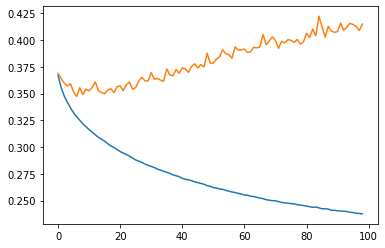

In [15]:
import matplotlib.pyplot as plt
plt.plot(loss_list[1:])
plt.plot(val_loss_list[1:])
plt.savefig('/project/hikaku_db/ziwei/Model_15/loss_plt_7.jpg')

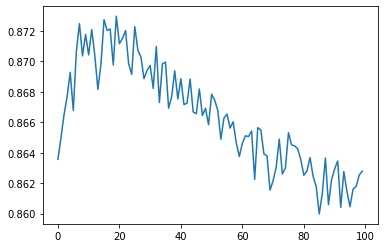

In [16]:
plt.plot(ac_list)
plt.savefig('/project/hikaku_db/ziwei/Model_15/ac_plt_7.jpg')

In [17]:
loss_list = pd.DataFrame([loss_list])
val_loss_list = pd.DataFrame([val_loss_list])
ac_list = pd.DataFrame([ac_list])
loss_list.to_csv('/project/hikaku_db/ziwei/Model_15/loss_list_7.csv',header=False,index=False)
val_loss_list.to_csv('/project/hikaku_db/ziwei/Model_15/val_loss_list_7.csv',header=False,index=False)
ac_list.to_csv('/project/hikaku_db/ziwei/Model_15/ac_list_7.csv',header=False,index=False)

accuracy of each class:
[0.92621721 0.40203798 0.8618548  0.89128306 0.81083306]


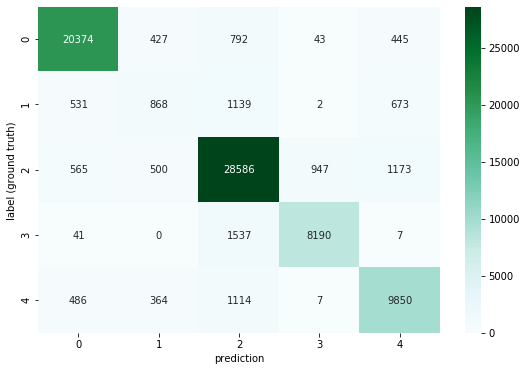

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred, y_true = pre, lab

# draw confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)                                
# accuracy of each class
per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)                    
class_names = ['0', '1', '2', '3', '4']
print('accuracy of each class:')
print(per_cls_acc)                                                          

# plot and save
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)     
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('/project/hikaku_db/ziwei/Model_15/confusion_matrix_7.png')

In [16]:
print(inputdat.shape)
inputdat=inputdat[0:1082,:,:]
input_subj=inputdat
print(input_subj.shape)
subj = Mydatasets(data=input_subj,label=label)
subj_dataloader = torch.utils.data.DataLoader(subj, batch_size = 512, shuffle=False)

NameError: name 'inputdat' is not defined

In [15]:
EPOCH = 1
loss_list=[]
los_min=10**10
val_loss_list=[]
ac_list=[]

for epoch in tqdm.tqdm(range(EPOCH)):
    with torch.no_grad():
        count=0
        running_loss=0.0
        pre=list()
        lab=list()
        for _, (inputs, labels) in enumerate(subj_dataloader, 0):
            inputs=inputs.to(DEVICE)
            labels=labels.to(DEVICE)
            outputs = Transmodel(inputs)
            loss =criterion(outputs, labels.squeeze())
            running_loss += loss.item()
            count+=1
            _, predicted = torch.max(F.softmax(outputs).data, 1)
            predicted=predicted.to('cpu')
            labels=labels.to('cpu')
            predicted=predicted.tolist()
            labels=labels.tolist()
            pre.append(predicted)
            lab.append(labels)
        loss_loss=running_loss/count
        val_loss_list.append(loss_loss)
        pre=sum(pre,[])
        lab=sum(lab,[])
        print('val_loss:',loss_loss)
        cl = classification_report(lab, pre,output_dict=True)
        print(cl)
        ac_list.append(cl['accuracy'])

  0%|          | 0/1 [00:00<?, ?it/s]


NameError: name 'subj_dataloader' is not defined

In [19]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
import numpy as np
def kappa(confusion_matrix):
    pe_rows = np.sum(confusion_matrix, axis=0)
    pe_cols = np.sum(confusion_matrix, axis=1)
    sum_total = sum(pe_cols)
    pe = np.dot(pe_rows, pe_cols) / float(sum_total ** 2)
    po = np.trace(confusion_matrix) / float(sum_total)
    return (po - pe) / (1 - pe)

In [88]:
for data, target in subj_dataloader:
    output = Transmodel(data.to(DEVICE))
    conf_matrix = confusion_matrix(output, target, conf_matrix)

In [89]:
conf_matrix

array([[2844.,  126.,   81.,    0.,   45.],
       [  36.,  189.,  153.,    0.,   36.],
       [  90.,   99., 3528.,  288.,  108.],
       [   0.,    0.,  342., 1017.,    0.],
       [   9.,    9.,    9.,    0.,  729.]], dtype=float32)

In [74]:
list=[[2844.,  126.,   81.,    0.,   45.],
       [  36.,  189.,  153.,    0.,   36.],
       [  90.,   99., 3528.,  288.,  108.],
       [   0.,    0.,  192., 1567.,    0.],
       [   29.,    29.,    29.,    29.,  450.]]

In [75]:
Confusion_Matrix = np.array(list)
K = kappa(Confusion_Matrix)
K

0.8037239362032368

In [76]:
cnf_matrix = Confusion_Matrix
attack_types = ['0', '1', '2', '3', '4']

Normalized confusion matrix
[[0.91860465 0.04069767 0.02616279 0.         0.01453488]
 [0.08695652 0.45652174 0.36956522 0.         0.08695652]
 [0.02188184 0.02407002 0.85776805 0.07002188 0.02625821]
 [0.         0.         0.10915293 0.89084707 0.        ]
 [0.05123675 0.05123675 0.05123675 0.05123675 0.795053  ]]


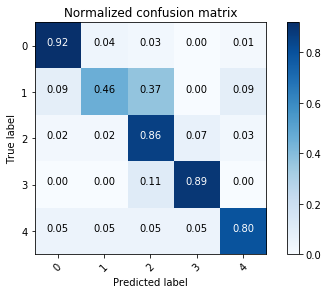

In [77]:
plot_confusion_matrix(cnf_matrix, classes=attack_types, normalize=True, title='Normalized confusion matrix')

In [101]:
matrix.to_csv('/project/hikaku_db/ziwei/Model_1/matrix_2.csv',encoding='gbk')

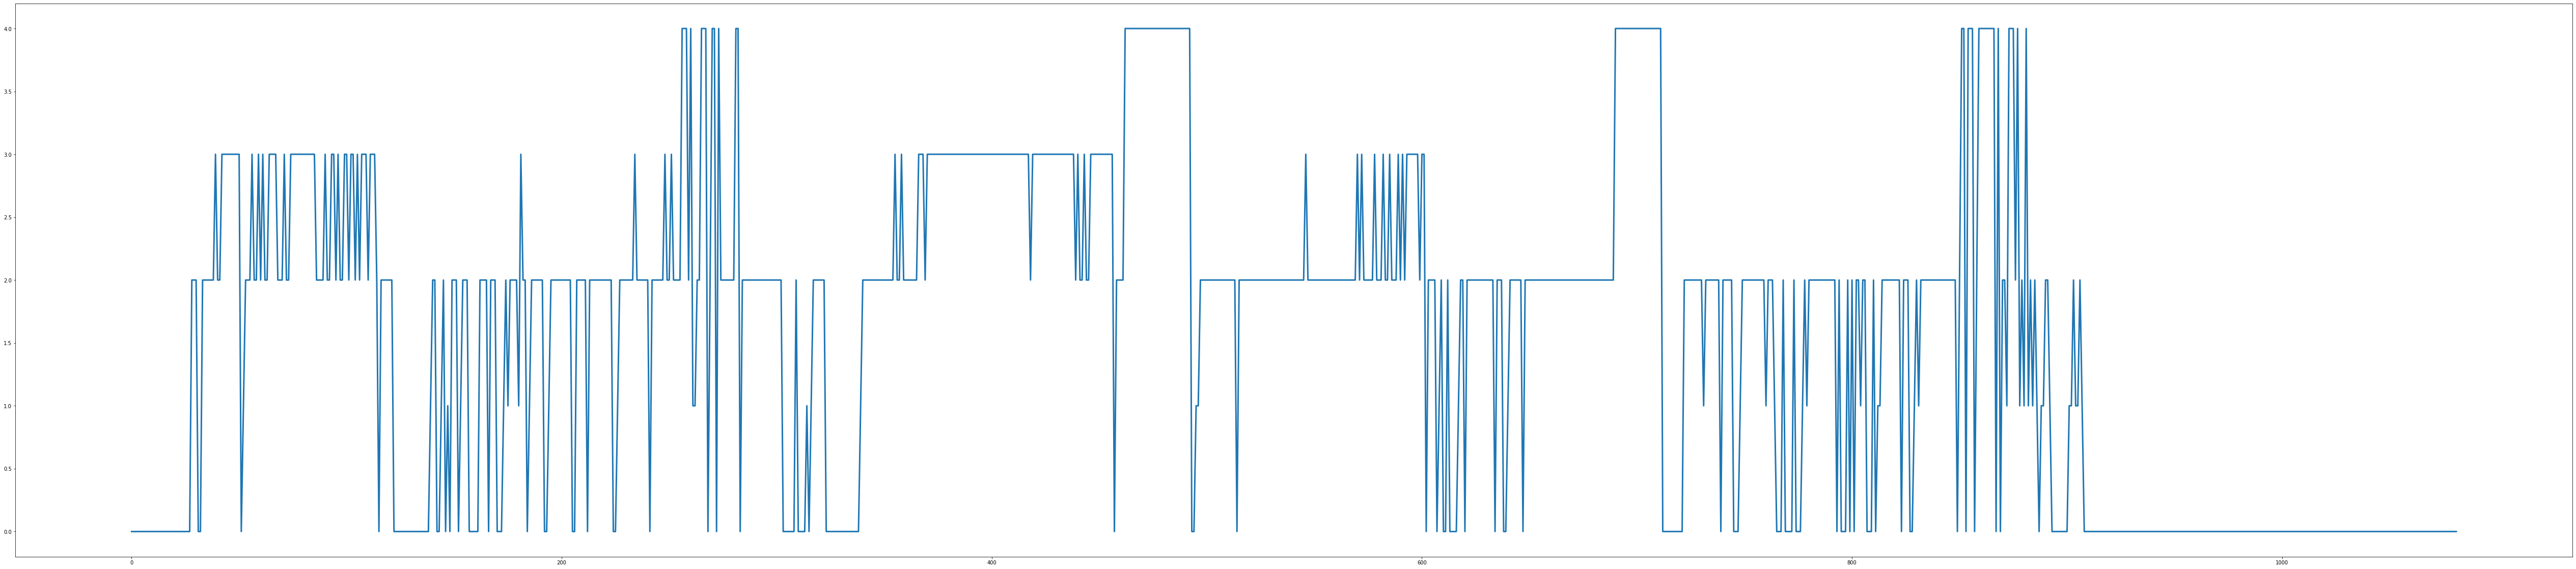

In [42]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 90, 20
plt.plot(pre[:1082],linewidth = '3')
plt.savefig('/project/hikaku_db/ziwei/Model_1/subj_pre.pdf')

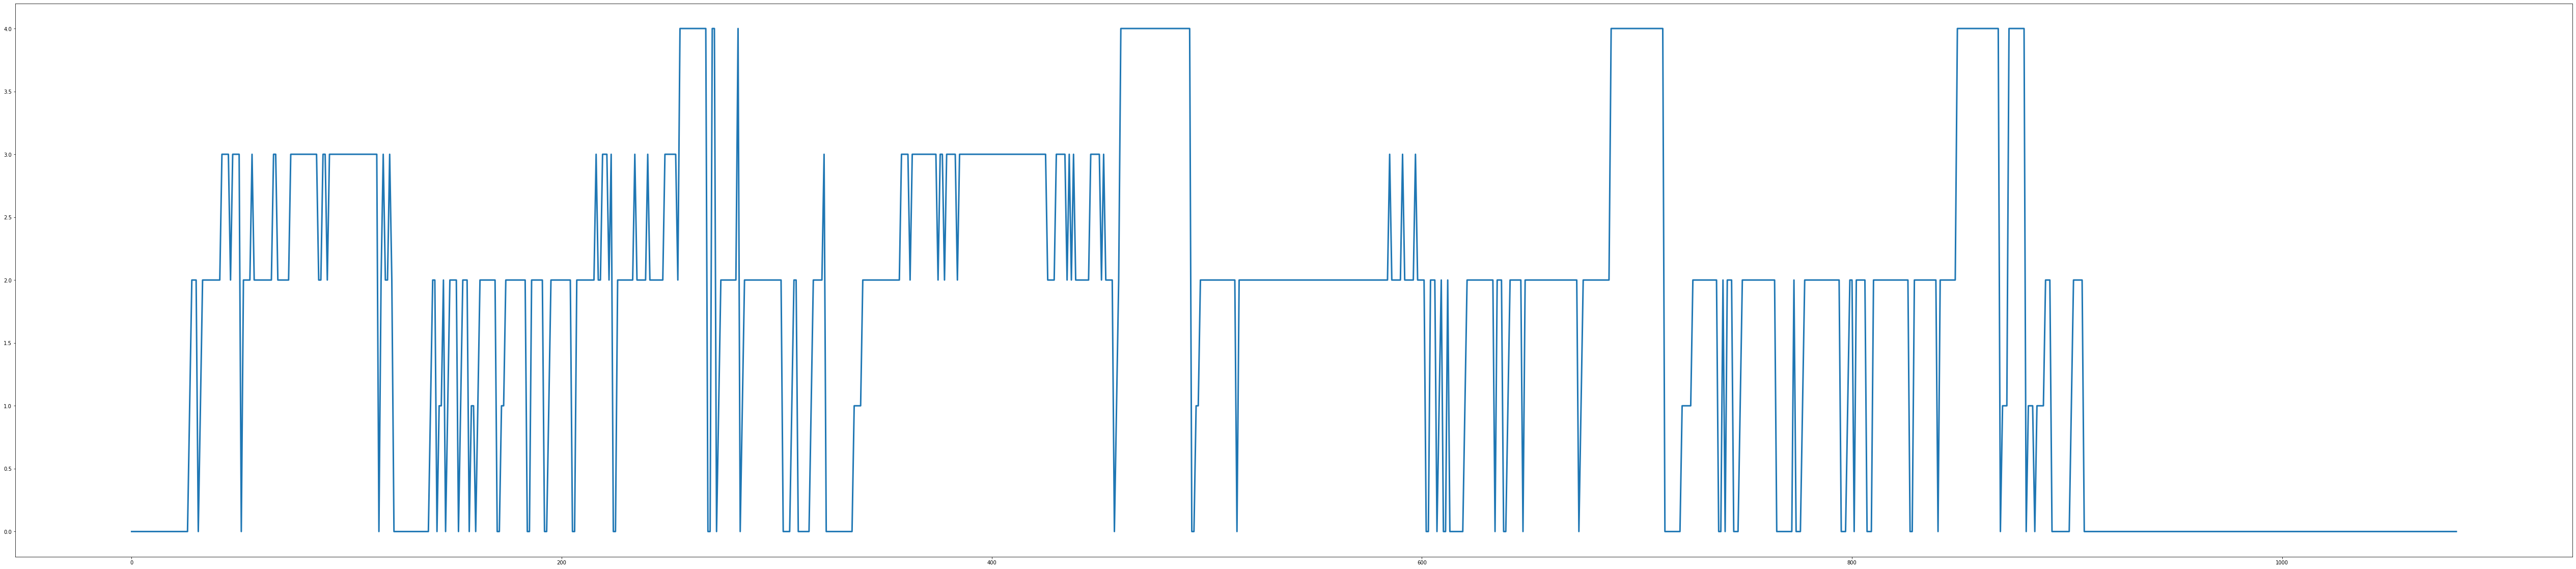

In [43]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 90, 20
plt.plot(lab[:1082],linewidth = '3')
plt.savefig('/project/hikaku_db/ziwei/Model_1/subj.pdf')

In [124]:
# import csv
# with open('/project/hikaku_db/ziwei/Model_1/ac_list_5.csv', newline='') as f:
#     reader1 = csv.reader(f)
#     data_ac_list = list(reader1)
#     data_ac_list=np.array(data_ac_list)
#     data_ac_list=data_ac_list.astype(np.float64)
#     plt.plot(data_ac_list[0])
#     #plt.savefig('/project/hikaku_db/ziwei/Model_1/ac_plt_5.jpg')

In [ ]:
# import csv
# with open('/project/hikaku_db/ziwei/Model_1/loss_list_5.csv', newline='') as f:
#     reader1 = csv.reader(f)
#     data_loss_list = list(reader1)
#     data_loss_list=np.array(data_loss_list)
#     data_loss_list=data_loss_list.astype(np.float64)
#     plt.plot(data_loss_list[0])
# with open('/project/hikaku_db/ziwei/Model_1/val_loss_list_5.csv', newline='') as f:
#     reader2 = csv.reader(f)
#     data_val_loss_list = list(reader2)
#     data_val_loss_list=np.array(data_val_loss_list)
#     data_val_loss_list=data_val_loss_list.astype(np.float64)
#     plt.plot(data_val_loss_list[0])
#     #plt.savefig('/project/hikaku_db/ziwei/Model_1/loss_plt_5.jpg')

In [3]:
from scipy import signal
import matplotlib.pyplot as plt

In [4]:
eog = np.load('/project/dsc-is/ziwei-y/EOG_seq_spec/EOG_L_1_800_30.npy')
eeg = np.load('/project/dsc-is/ziwei-y/EEG_C3_seq/np_c3_1_800_30.npy')

26
26


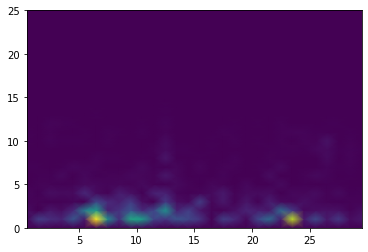

In [30]:
f, t, Sxx = signal.spectrogram(eog[34,:], fs=50, nperseg= 50, noverlap = 0, nfft =50)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')
plt.plot()
print(len(Sxx))
print(len(f))
Sxx.shape
plt.savefig('/project/hikaku_db/ziwei/Model_1/EOGspec.pdf')

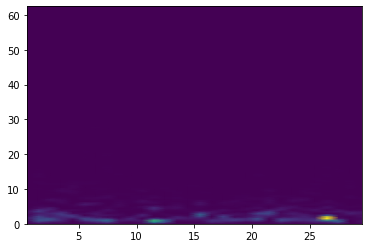

126
126


(126, 30)

In [26]:
f, t, Sxx = signal.spectrogram(eeg[2336,:], fs=125, nperseg= 125, noverlap = 0, nfft =250)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')
plt.show()
print(len(Sxx))
print(len(f))
Sxx.shape